# Data Exploration

in diesem Notebook wird ein erster Blick auf die Daten geworfen. Es wird untersucht, wie viele Datenpunkte es gibt, wie viele verschiedene Codons es gibt und wie die Codons verteilt sind.

In [1]:
# Imports for this Notebook
from collections import defaultdict as ddict
from itertools import product

from Bio.Seq import Seq
from Bio.Data import CodonTable
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
from matplotlib.colors import ListedColormap

import seaborn as sns

import sys
sys.path.append('../scripts')
import ml_helper as mlh

### Bereinigte Daten einlesen

In [2]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

dfs = dict()
for organism in organisms:
    dfs[organism] = pd.read_pickle(f"../data/{organism}/cleanedData.pkl")
    dfs[organism]['codons'] = dfs[organism]['sequence'].apply(group_codons)

In [3]:
# die ersten 5 Zeilen der Daten für den Menschen
dfs[organisms[2]].head()

,id,description,sequence,translation,seguid,codons
0,lcl|NC_000001.11_cds_NP_001005484.2_1,lcl|NC_000001.11_cds_NP_001005484.2_1 [gene=OR...,"(A, T, G, A, A, G, A, A, G, G, T, A, A, C, T, ...","(M, K, K, V, T, A, E, A, I, S, W, N, E, S, T, ...",UBucs6snpgswwVrEU8ftvJeqrk4,"[ATG, AAG, AAG, GTA, ACT, GCA, GAG, GCT, ATT, ..."
1,lcl|NC_000001.11_cds_XP_047292308.1_2,lcl|NC_000001.11_cds_XP_047292308.1_2 [gene=LO...,"(A, T, G, C, C, T, A, G, A, C, A, C, A, C, A, ...","(M, P, R, H, T, H, P, Y, S, A, C, I, P, G, L, ...",fmMptRYpXZYIQlpzWnOAWCNHMu0,"[ATG, CCT, AGA, CAC, ACA, CAT, CCT, TAC, TCT, ..."
2,lcl|NC_000001.11_cds_NP_001005221.2_3,lcl|NC_000001.11_cds_NP_001005221.2_3 [gene=OR...,"(A, T, G, G, A, T, G, G, A, G, A, G, A, A, T, ...","(M, D, G, E, N, H, S, V, V, S, E, F, L, F, L, ...",k7sK/6Gz36O+87lKFXrtHbVIfis,"[ATG, GAT, GGA, GAG, AAT, CAC, TCA, GTG, GTA, ..."
3,lcl|NC_000001.11_cds_XP_011540840.1_4,lcl|NC_000001.11_cds_XP_011540840.1_4 [gene=LO...,"(A, T, G, C, G, T, A, G, A, C, A, C, A, C, A, ...","(M, R, R, H, T, H, P, Y, S, A, R, I, P, G, L, ...",KQYivLF3IdHzEQdKOvxqTipU9Mk,"[ATG, CGT, AGA, CAC, ACA, CAT, CCT, TAC, TCT, ..."
9,lcl|NC_000001.11_cds_NP_001372569.1_10,lcl|NC_000001.11_cds_NP_001372569.1_10 [gene=S...,"(A, T, G, C, C, G, G, C, G, G, T, C, A, A, G, ...","(M, P, A, V, K, K, E, F, P, G, R, E, D, L, A, ...",+xn2CC4cXYgtMIZb/rBu8OmtXgQ,"[ATG, CCG, GCG, GTC, AAG, AAG, GAG, TTC, CCG, ..."


### Datenanalyse

In [4]:
from Bio import SeqIO

In [5]:
original_nums = {}
for organism in organisms:
    num = 0
    extra = ""
    if organism == "E.Coli":
        extra = "/GCA_000005845.2"
    for index,record in enumerate(SeqIO.parse(f"../data/{organism}{extra}/cds_from_genomic.fna", "fasta")):
        num += 1
    original_nums[organism] = num
    print(organism)
    display(num)

E.Coli


4315

Drosophila.Melanogaster


30802

Homo.Sapiens


145346

Folgende Fehler sind bei den Daten aufgefallen:
- **modThree** Codons sind nicht immer 3 Zeichen lang
- **stopCodon** Sequenzen enthalten kein oder mehrere Stop-Codons
- **doubleData** Sequenzen sind doppelt vorhanden
- **noStartCodon** Sequenzen enthalten kein Start-Codon

In [6]:
report_data = {}
for organism in organisms:
    report_data[organism] = pd.read_pickle(f"../data/{organism}/reportData.pkl")
    report_data[organism]['Total'] = report_data[organism].sum(axis=1)
    display(report_data[organism])

,modThree,stopCodon,doubleData,noStartCodon,Total
1,0,4,30,425,459
2,0,4,30,425,459
3,0,4,30,425,459
4,0,4,30,425,459


,modThree,stopCodon,doubleData,noStartCodon,Total
1,61,507,8434,126,9128
2,61,507,8434,126,9128
3,61,507,8434,126,9128
4,61,507,8434,126,9128


,modThree,stopCodon,doubleData,noStartCodon,Total
1,881,185,52256,633,53955
2,881,185,52256,633,53955
3,881,185,52256,633,53955
4,881,185,52256,633,53955


In [7]:
for organism in organisms:
    removed = report_data[organism]["Total"]
    print(f"{organism} - Should have left: {original_nums[organism] - removed[1]}")

E.Coli - Should have left: 3856
Drosophila.Melanogaster - Should have left: 21674
Homo.Sapiens - Should have left: 91391


#### Länge der Aminosäuresequenzen

In [8]:
def print_df_info(df):
    print(f"Anzahl der Sequenzen: {len(df.index)}")
    print(f"Kürzeste Sequenz: {df['translation'].apply(len).min()}")
    print(f"Längste Sequenz: {df['translation'].apply(len).max()}")
    print(f"Durchschnittliche Länge: {df['translation'].apply(len).mean():.2f}")
    print(f"Median: {df['translation'].apply(len).median()}")

In [9]:
for organism, df in dfs.items():
    print("--------"+organism+"--------")
    print_df_info(df)
    print()

--------E.Coli--------
Anzahl der Sequenzen: 3856
Kürzeste Sequenz: 8
Längste Sequenz: 2358
Durchschnittliche Länge: 309.34
Median: 273.0

--------Drosophila.Melanogaster--------
Anzahl der Sequenzen: 21674
Kürzeste Sequenz: 9
Längste Sequenz: 22949
Durchschnittliche Länge: 689.89
Median: 469.0

--------Homo.Sapiens--------
Anzahl der Sequenzen: 91389
Kürzeste Sequenz: 12
Längste Sequenz: 35991
Durchschnittliche Länge: 715.88
Median: 518.0



#### Histogramm der Längen der Aminosäuresequenzen

In [10]:
def show_sequence_length_hist(df, organism):
    sequence_lengths = df['translation'].apply(len)

    plt.hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black')

    plt.xlabel('Anzahl der Aminosäuren einer Sequenz')
    plt.ylabel('Häufigkeit')
    plt.title(f'Häufigkeitsverteilung der Aminosäuresequenzlängen\nbeim Organismus {organism}')

    plt.show()

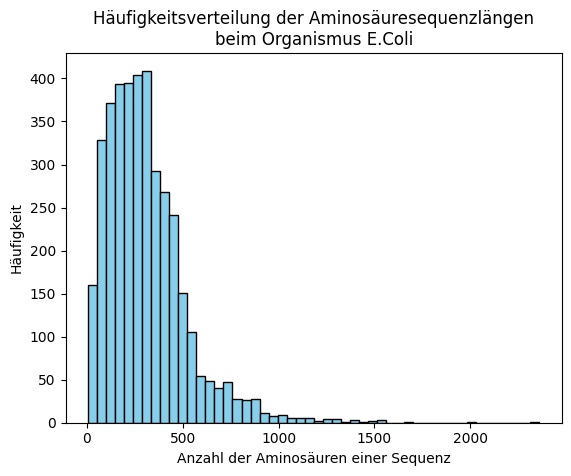

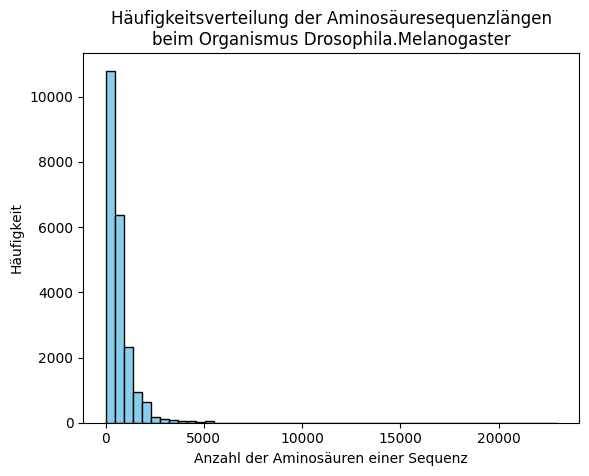

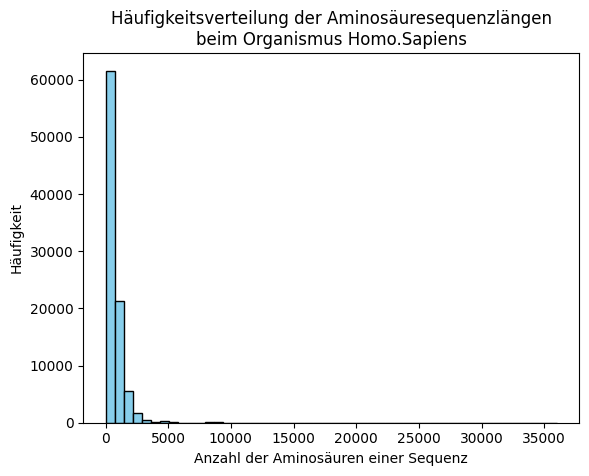

In [11]:
for organism, df in dfs.items():
    show_sequence_length_hist(df, organism)

### Histogramm Aminosäureverteilung

In [12]:
def get_codon_amino_acid_frequencies(organism):
    codon_amino_acid_frequencies = {}
    total = 0
    for _, row in dfs[organism].iterrows():
        for j, codon in enumerate(row['codons']):
            amino_acid = row['translation'][j]
            if amino_acid not in codon_amino_acid_frequencies:
                codon_amino_acid_frequencies[amino_acid] = {"total": 0}
            if codon not in codon_amino_acid_frequencies[amino_acid]:
                codon_amino_acid_frequencies[amino_acid][codon] = 0
            codon_amino_acid_frequencies[amino_acid]["total"] += 1
            codon_amino_acid_frequencies[amino_acid][codon] += 1
            total += 1
    codon_amino_acid_frequencies["total"] = total
    return codon_amino_acid_frequencies

In [13]:
# %%time

# for organism in organisms:
#     start_time = time.time()
#     codon_amino_acid_frequencies = get_codon_amino_acid_frequencies(organism)
#     with open(f'../data/{organism}/codon_amino_acid_frequencies.pkl', 'wb') as file:
#         pkl.dump(codon_amino_acid_frequencies, file)
#     print(f"Finished {organism} in {time.time() - start_time} seconds.")

In [14]:
codon_amino_acid_frequencies = {}
for organism in organisms:
    with open(f'../data/{organism}/codon_amino_acid_frequencies.pkl', 'rb') as file:
        codon_amino_acid_frequencies[organism] = pkl.load(file)

In [15]:
{codon: round(num / codon_amino_acid_frequencies[organisms[0]]['A']['total'],2) for codon, num in codon_amino_acid_frequencies[organisms[0]]['A'].items() if codon != 'total'}

{'GCG': 0.36, 'GCA': 0.21, 'GCC': 0.27, 'GCT': 0.16}

In [16]:
def get_number_synonyme_codons(amino_acid):
    return len(mlh.amino_acids_to_codons[amino_acid])

In [17]:
relative_frequencies = {}
def plot_relative_frequency(codon_amino_acid_frequencies, organisms, organism_names):
    # Colors for each organism
    colors = ['#6497b1', '#005b96', '#011f4b']

    # Calculate relative frequencies for each organism
    for organism in organisms:
        total_codons = codon_amino_acid_frequencies[organism]['total']
        amino_acids = {amino_acid: (codon_amino_acid_frequencies[organism][amino_acid]['total'] / total_codons) for amino_acid in codon_amino_acid_frequencies[organism] if amino_acid != 'total'}
        relative_frequencies[organism] = amino_acids

    # Sort amino acids based on their frequencies in E.Coli
    sorted_amino_acids = sorted(relative_frequencies[organisms[0]].items(), key=lambda item: item[1], reverse=True)

    # Plotting
    plt.figure(figsize=(12, 6))
    bar_width = 0.25  # Width of each bar

    for i, (amino_acid, _) in enumerate(sorted_amino_acids):
        x = [i + j * bar_width for j in range(len(organisms))]  # X coordinates for each organism's bars

        for j, organism in enumerate(organisms):
            frequency = relative_frequencies[organism].get(amino_acid, 0)  # Get relative frequency, default to 0 if not present
            plt.bar(x[j], frequency, color=colors[j], width=bar_width, label=organism if i == 0 else None)

    # Set x-axis labels and title
    plt.xlabel('Amino acid with amount of corresponding synonyme codons')
    plt.ylabel('Relative frequency')
    plt.title('Relative frequency of amino acids over all sequences of the three analyzed organisms', fontsize=16)
    
    # Set x-axis tick labels to amino acids
    mlh.amino_acids_to_codons
    plt.xticks(
        [i + (len(organisms) - 1) * bar_width / 2 for i in range(len(sorted_amino_acids))],
        [f'{amino_acid}\n({get_number_synonyme_codons(amino_acid)})' for amino_acid, _ in sorted_amino_acids]
    )
    
    # Add legend
    plt.legend()

    plt.tight_layout()
    plt.show()


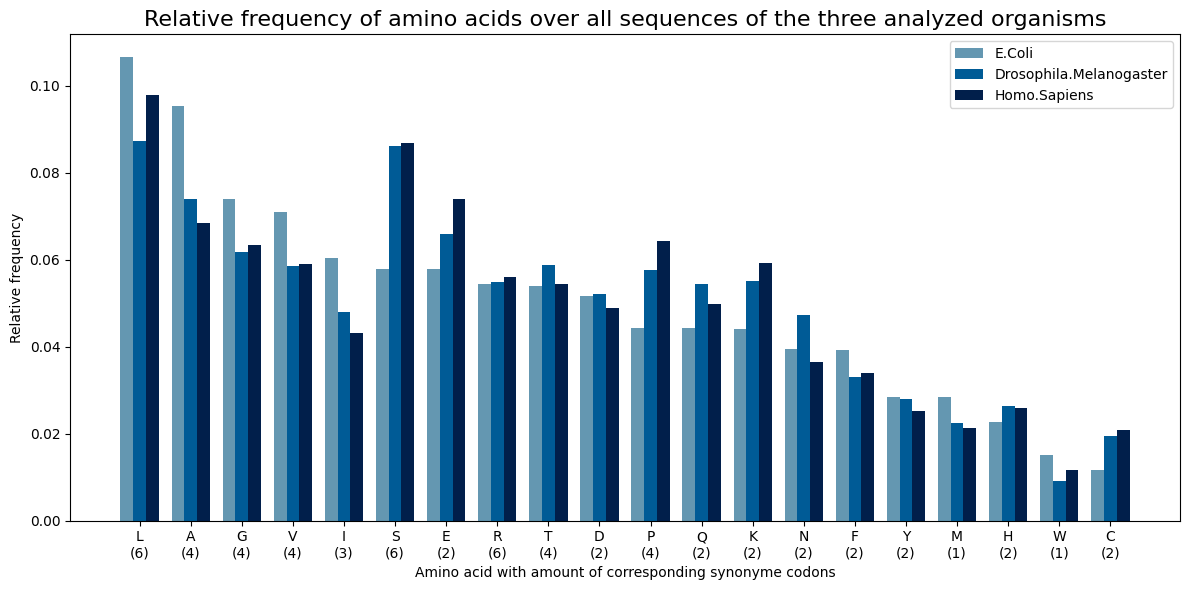

In [18]:
plot_relative_frequency(codon_amino_acid_frequencies, organisms, ["E.C.", "D.M.", "H.S."])

In [19]:
for organism in organisms:
    relative_frequency = relative_frequencies[organism]
    avg_amino_acids = 0
    for amino_acid in relative_frequency:
        if amino_acid == 'X':
            continue
        avg_amino_acids += relative_frequency[amino_acid] * len(mlh.amino_acids_to_codons[amino_acid])
    print(f"Average number of codons per amino acid in {organism}: {avg_amino_acids}")

Average number of codons per amino acid in E.Coli: 3.5685611382926283
Average number of codons per amino acid in Drosophila.Melanogaster: 3.550963591143657
Average number of codons per amino acid in Homo.Sapiens: 3.5921103675523094


#### Häufigkeit der Codons (Codon Usage Frequency)

In [20]:
def get_codon_frequency(df):
    codon_frequency = ddict(int)
    for _, row in df.iterrows():
        sequence = row['sequence']
        if len(sequence) % 3 != 0:
            print(f"Sequence length is not a multiple of 3")
            continue

        codons = [str(sequence[i:i+3]) for i in range(0, len(sequence), 3)]
        for codon in codons:
            codon_frequency[codon] += 1

    return codon_frequency

In [21]:
codon_frequencies = ddict(int)
for organism, df in dfs.items():
    codon_frequencies[organism] = get_codon_frequency(df)
    print(f"Anzahl unterschiedlicher Codons bei {organism}: {len(codon_frequencies[organism].keys())}")

Anzahl unterschiedlicher Codons bei E.Coli: 61
Anzahl unterschiedlicher Codons bei Drosophila.Melanogaster: 61
Anzahl unterschiedlicher Codons bei Homo.Sapiens: 61


In [22]:
codon_frequencies[organisms[0]]

defaultdict(int,
            {'ATG': 33789,
             'AAA': 40548,
             'CGC': 26170,
             'ATT': 36610,
             'AGC': 19204,
             'ACC': 28326,
             'ATC': 30441,
             'ACA': 8290,
             'GGT': 29833,
             'AAC': 26008,
             'GCG': 40628,
             'GGC': 35954,
             'CGA': 4042,
             'GTG': 31301,
             'TTG': 16114,
             'AAG': 12128,
             'TTC': 19969,
             'TCA': 8381,
             'GCA': 24171,
             'AAT': 21004,
             'GAA': 47661,
             'CGT': 24972,
             'TTT': 26809,
             'CTG': 63486,
             'GTT': 22029,
             'GCC': 30706,
             'GAT': 38474,
             'AGG': 1255,
             'CAG': 34443,
             'GGG': 13146,
             'GTC': 18231,
             'CTC': 13281,
             'TCT': 10130,
             'CCC': 6449,
             'CAC': 11609,
             'GCT': 18217,
             'TT

#### relative Häufigkeit der Codons (Codon Usage Bias)

In [23]:
translation_dict = ddict(list)
for codon in codon_frequencies[organisms[0]]:
    translation = str(Seq(codon).translate())
    translation_dict[translation].append(codon)

translation_dict

defaultdict(list,
            {'M': ['ATG'],
             'K': ['AAA', 'AAG'],
             'R': ['CGC', 'CGA', 'CGT', 'AGG', 'CGG', 'AGA'],
             'I': ['ATT', 'ATC', 'ATA'],
             'S': ['AGC', 'TCA', 'TCT', 'AGT', 'TCG', 'TCC'],
             'T': ['ACC', 'ACA', 'ACG', 'ACT'],
             'G': ['GGT', 'GGC', 'GGG', 'GGA'],
             'N': ['AAC', 'AAT'],
             'A': ['GCG', 'GCA', 'GCC', 'GCT'],
             'V': ['GTG', 'GTT', 'GTC', 'GTA'],
             'L': ['TTG', 'CTG', 'CTC', 'TTA', 'CTT', 'CTA'],
             'F': ['TTC', 'TTT'],
             'E': ['GAA', 'GAG'],
             'D': ['GAT', 'GAC'],
             'Q': ['CAG', 'CAA'],
             'P': ['CCC', 'CCG', 'CCT', 'CCA'],
             'H': ['CAC', 'CAT'],
             'C': ['TGC', 'TGT'],
             'Y': ['TAC', 'TAT'],
             'W': ['TGG']})

In [24]:
def calculate_codon_usage_frequency(codon_frequency):
    codon_usage_frequency = {amino_acid: {codon:0 for codon in translation_dict[amino_acid]} for amino_acid in translation_dict.keys()}
    for amino_acid, codon_dict in codon_usage_frequency.items():
        amino_acid_frequency = 0
        for codon in codon_dict:
            amino_acid_frequency += codon_frequency[codon]
        for codon in codon_dict:
            codon_usage_frequency[amino_acid][codon] = round(codon_frequency[codon] / amino_acid_frequency, 4)
    return codon_usage_frequency


In [25]:
codon_usage_bias = dict()

for organism, df in dfs.items():
   codon_usage_bias[organism] = calculate_codon_usage_frequency(codon_frequencies[organism])

In [26]:
codon_usage_bias[organisms[0]]['A']

{'GCG': 0.3573, 'GCA': 0.2125, 'GCC': 0.27, 'GCT': 0.1602}

In [27]:
codon_usage_bias[organisms[2]]['A']

{'GCG': 0.0913, 'GCA': 0.2512, 'GCC': 0.3794, 'GCT': 0.2781}

In [28]:
codon_usage_bias[organisms[0]]

{'M': {'ATG': 1.0},
 'K': {'AAA': 0.7698, 'AAG': 0.2302},
 'R': {'CGC': 0.4038,
  'CGA': 0.0624,
  'CGT': 0.3853,
  'AGG': 0.0194,
  'CGG': 0.0939,
  'AGA': 0.0352},
 'I': {'ATT': 0.5083, 'ATC': 0.4227, 'ATA': 0.069},
 'S': {'AGC': 0.2785,
  'TCA': 0.1215,
  'TCT': 0.1469,
  'AGT': 0.1492,
  'TCG': 0.1539,
  'TCC': 0.15},
 'T': {'ACC': 0.4397, 'ACA': 0.1287, 'ACG': 0.2658, 'ACT': 0.1659},
 'G': {'GGT': 0.3382, 'GGC': 0.4075, 'GGG': 0.149, 'GGA': 0.1053},
 'N': {'AAC': 0.5532, 'AAT': 0.4468},
 'A': {'GCG': 0.3573, 'GCA': 0.2125, 'GCC': 0.27, 'GCT': 0.1602},
 'V': {'GTG': 0.3695, 'GTT': 0.2601, 'GTC': 0.2152, 'GTA': 0.1552},
 'L': {'TTG': 0.1269,
  'CTG': 0.4998,
  'CTC': 0.1046,
  'TTA': 0.13,
  'CTT': 0.1025,
  'CTA': 0.0364},
 'F': {'TTC': 0.4269, 'TTT': 0.5731},
 'E': {'GAA': 0.6921, 'GAG': 0.3079},
 'D': {'GAT': 0.6254, 'GAC': 0.3746},
 'Q': {'CAG': 0.6538, 'CAA': 0.3462},
 'P': {'CCC': 0.1222, 'CCG': 0.5302, 'CCT': 0.1574, 'CCA': 0.1901},
 'H': {'CAC': 0.4309, 'CAT': 0.5691},
 'C':

##### Beispiel: Codon Usage Bias für Leucin

In [29]:
for organism in codon_usage_bias:
    print("--------"+organism+"--------")
    print(codon_usage_bias[organism]['L'])

--------E.Coli--------
{'TTG': 0.1269, 'CTG': 0.4998, 'CTC': 0.1046, 'TTA': 0.13, 'CTT': 0.1025, 'CTA': 0.0364}
--------Drosophila.Melanogaster--------
{'TTG': 0.1827, 'CTG': 0.4167, 'CTC': 0.152, 'TTA': 0.0539, 'CTT': 0.101, 'CTA': 0.0937}
--------Homo.Sapiens--------
{'TTG': 0.1385, 'CTG': 0.3692, 'CTC': 0.1811, 'TTA': 0.0906, 'CTT': 0.144, 'CTA': 0.0767}


Vergleichswerte von https://www.genscript.com/tools/codon-frequency-table :

```text
--------E.Coli--------
{'TTG': 0.13, 'CTG': 0.47, 'CTC': 0.1, 'TTA': 0.14, 'CTT': 0.12, 'CTA': 0.04}
--------DrosophilaMelanogaster--------
{'TTG': 0.18, 'CTG': 0.43, 'CTC': 0.15, 'TTA': 0.05, 'CTT': 0.1, 'CTA': 0.09}
--------Homo Sapiens--------
{'TTG': 0.13, 'CTG': 0.41, 'CTC': 0.20, 'TTA': 0.07, 'CTT': 0.13, 'CTA': 0.07}
```

### Codon Index Visualisierung

In [30]:
possible_amino_acids = [('A', 'Alanine'), ('R', 'Arginine'), ('N', 'Asparagine'), ('D', 'Aspartic acid'), ('C', 'Cysteine'),
                        ('E', 'Glutamic acid'), ('Q', 'Glutamine'), ('G', 'Glycine'), ('H', 'Histidine'), ('I', 'Isoleucine'),
                        ('L', 'Leucine'), ('K', 'Lysine'), ('M', 'Methionine'), ('F', 'Phenylalanine'), ('P', 'Proline'),
                        ('S', 'Serine'), ('T', 'Threonine'), ('W', 'Tryptophan'), ('Y', 'Tyrosine'), ('V', 'Valine')]

# all possible Codons
codon_list = ["".join(i) for i in list(product("TCAG", repeat=3))]

# all amino acids and their corresponding codons
translation_table = ddict(list)
for codon in codon_list:
    tr = str(Seq(codon).translate())
    translation_table[tr].append(codon)

print("codon_list", codon_list)
print("translation_table", dict(translation_table))

codon_list ['TTT', 'TTC', 'TTA', 'TTG', 'TCT', 'TCC', 'TCA', 'TCG', 'TAT', 'TAC', 'TAA', 'TAG', 'TGT', 'TGC', 'TGA', 'TGG', 'CTT', 'CTC', 'CTA', 'CTG', 'CCT', 'CCC', 'CCA', 'CCG', 'CAT', 'CAC', 'CAA', 'CAG', 'CGT', 'CGC', 'CGA', 'CGG', 'ATT', 'ATC', 'ATA', 'ATG', 'ACT', 'ACC', 'ACA', 'ACG', 'AAT', 'AAC', 'AAA', 'AAG', 'AGT', 'AGC', 'AGA', 'AGG', 'GTT', 'GTC', 'GTA', 'GTG', 'GCT', 'GCC', 'GCA', 'GCG', 'GAT', 'GAC', 'GAA', 'GAG', 'GGT', 'GGC', 'GGA', 'GGG']
translation_table {'F': ['TTT', 'TTC'], 'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'], 'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'], 'Y': ['TAT', 'TAC'], '*': ['TAA', 'TAG', 'TGA'], 'C': ['TGT', 'TGC'], 'W': ['TGG'], 'P': ['CCT', 'CCC', 'CCA', 'CCG'], 'H': ['CAT', 'CAC'], 'Q': ['CAA', 'CAG'], 'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'], 'I': ['ATT', 'ATC', 'ATA'], 'M': ['ATG'], 'T': ['ACT', 'ACC', 'ACA', 'ACG'], 'N': ['AAT', 'AAC'], 'K': ['AAA', 'AAG'], 'V': ['GTT', 'GTC', 'GTA', 'GTG'], 'A': ['GCT', 'GCC', 'GCA', 'GCG'], 'D'

In [31]:
org_colors = ['#EF476F', '#FFD166', '#06D6A0', '#118AB2', '#ff66ff', '#00ffff', '#073B4C', "black"] 
def get_colors(amino, colors=org_colors):
    """
    Returns a list of colors for the codons of the given amino acid.
    """

    syn_codon =  len(translation_table[amino[0]])
    color_used = colors[:syn_codon].copy()
    color_used = color_used + colors[-2:]
    return color_used

In [32]:
def get_color_matrix(records, selected_aa, show_records, colors, len_threshold=0.3, start_padding=False):
    color_matrix = []

    max_len = max(len(record) for record in records) // 3
    avg_len = (sum(len(record) for record in records) // 3) / len(records)
    if len_threshold is not None:
        max_threshold = int(avg_len * (1 + len_threshold))
        min_threshold = int(avg_len * (1 - len_threshold))
    else:
        max_threshold = max_len
        min_threshold = 0

    print("max_len", max_len, "avg_len", round(avg_len, 2))
    color_padding = len(colors) - 1
    color_default = len(colors) - 2

    if show_records is not None:
        records = records[:show_records]
    else:
        records = records

    for record in records:
        #if len(record) is a outlier, we can skip it:
        if len_threshold is not None and (len(record) // 3 > max_threshold or len(record) // 3 < min_threshold):
            continue
        selected_codons = translation_table[selected_aa[0]]
        codons = [record[i:i + 3] for i in range(0, len(record), 3)]
        codon_ids = [selected_codons.index(c) if c in selected_codons else -1 for c in codons]
        # Create a list to hold the color indices for each codon
        color_indices = [idx if idx >= 0 else color_default for idx in codon_ids]
        # create padding for length differences
        padding = [color_padding] * (max_threshold - len(color_indices))
        if start_padding:

            color_indices = padding + color_indices
        else:
            # Pad color_indices with -1 to make it the same length as max_len
            #color_indices += [color_padding] * (max_threshold - len(color_indices))
            color_indices = color_indices + padding
        color_matrix.append(color_indices)



    # sort color_matrix based on length for first color_padding elements
    len_of_codons = [len([1 for i in x if i != color_padding]) for x in color_matrix]
    # sort color_matrix based on length for first color_padding elements
    color_matrix = [x for _, x in sorted(zip(len_of_codons, color_matrix), key=lambda pair: pair[0])]

    # Convert color_matrix to a 2D numpy array
    return np.array(color_matrix)

In [33]:
def visualize_color_matrix(color_matrix, selected_aa, colors):

    cmap = ListedColormap(colors)

    plt.figure(figsize=(20, 5))
    plt.imshow(color_matrix, aspect='auto', cmap=cmap, vmin=0, vmax=len(colors) - 1)
    plt.xlabel('Codon Index in Codon Sequenz')
    plt.title(f'Verteilung Codons für {color_matrix.shape[0]} Sequenzen für die Aminosäure: {selected_aa[1]}')
    plt.ylabel('Anzahl an Sequenzen')  # Hide y-axis ticks

    # Create a custom legend
    unique_codon_ids = list(set(range(0, len(translation_table[selected_aa[0]]))))
    print("unique_codon_ids", unique_codon_ids)
    unique_selected_codons = [translation_table[selected_aa[0]][i] for i in unique_codon_ids] + ['not codon', 'padding']
    print("unique_selected_codons", unique_selected_codons)
    patches = [mpl.patches.Patch(color=colors[i % len(colors)], label=unique_selected_codons[i]) for i in range(len(unique_selected_codons))]
    print([(colors[i % len(colors)], unique_selected_codons[i]) for i in range(len(unique_selected_codons))])
    plt.legend(handles=patches, loc='upper right')

    plt.show()


Organism: E.Coli
Selected Amino Acid: ('A', 'Alanine')
max_len 2358 avg_len 309.34
color_matrix shape: (102, 402)
unique_codon_ids [0, 1, 2, 3]
unique_selected_codons ['GCT', 'GCC', 'GCA', 'GCG', 'not codon', 'padding']
[('#EF476F', 'GCT'), ('#FFD166', 'GCC'), ('#06D6A0', 'GCA'), ('#118AB2', 'GCG'), ('#073B4C', 'not codon'), ('black', 'padding')]


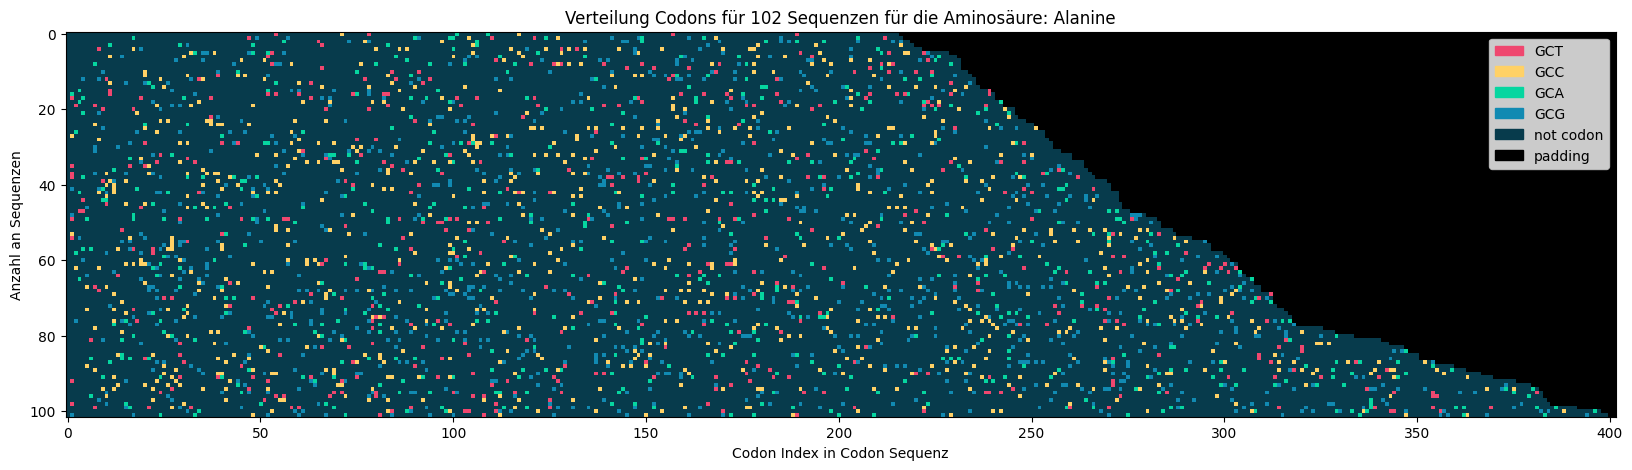

In [34]:
# selected organism
organism = organisms[0]
# selected amino acid
selected_amino_acid =  possible_amino_acids[0]
print("Organism:", organism)
print("Selected Amino Acid:", selected_amino_acid)

# wether the sequences are padded at the start or the end
start_padding = False

# only rows with a length between (1-threshold) and (1+threshold) times the average length are shown
len_threshold = 0.3

colors = get_colors(selected_amino_acid, colors=org_colors)
color_matrix = get_color_matrix(dfs[organism]["sequence"], show_records=252, selected_aa=selected_amino_acid, colors=colors, len_threshold=len_threshold, start_padding=start_padding)
print("color_matrix shape:", color_matrix.shape)

visualize_color_matrix(color_matrix, colors=colors, selected_aa=selected_amino_acid)

- padding: Auffüllung um die gleiche Länge zu erreichen
- sortiert nach Sequenzlänge
- ausgewählte Stichprobe nach: +-0.3 Durchschnittslänge der Sequenzen

In [35]:
color_padding = len(colors) - 1
color_default = len(colors) - 2

def get_only_codons(start_padding=False):
    # Filter out color_padding and color_default
    color_matrix_only_codon = [[idx for idx in row if idx != color_padding and idx != color_default] for row in color_matrix]
    # Find the length of the longest row
    max_length = max(len(row) for row in color_matrix_only_codon)
    # Pad each row with color_padding to make it the same length as the longest row
    if start_padding:
        color_matrix_only_codon = [[color_padding]*(max_length - len(row)) + row for row in color_matrix_only_codon]
    else:
        color_matrix_only_codon = [row + [color_padding]*(max_length - len(row)) for row in color_matrix_only_codon]
    # sort color_matrix based on length for first color_padding elements
    len_of_codons = [len([1 for i in x if i != color_padding]) for x in color_matrix_only_codon]
    # sort color_matrix based on length for first color_padding elements
    color_matrix_only_codon = [x for _, x in sorted(zip(len_of_codons, color_matrix_only_codon), key=lambda pair: pair[0])]
    return np.array(color_matrix_only_codon)
color_matrix_only_codon = get_only_codons(start_padding=start_padding)

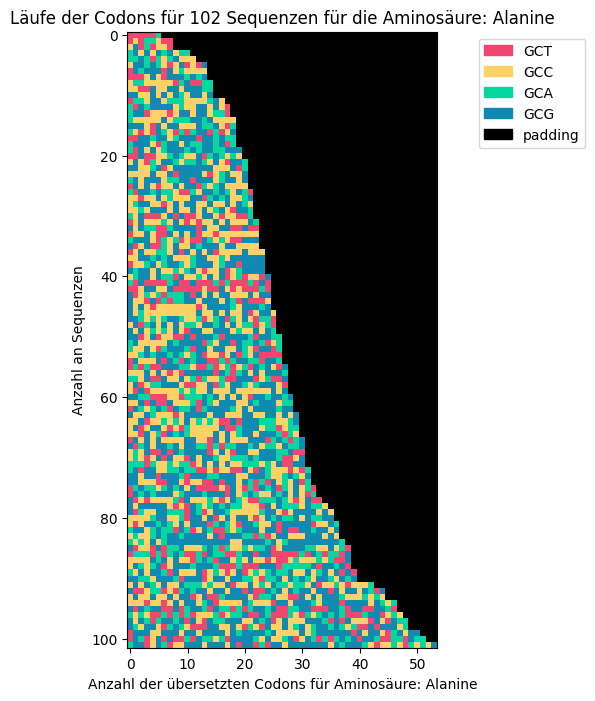

In [36]:
def visualize_runs(df_only_codon, selected_aa, colors):
    # create a colormap
    cmap = ListedColormap(colors)
    # Plotting
    plt.figure(figsize=(4, 8))
    plt.imshow(df_only_codon, aspect='auto', cmap=cmap, vmin=0, vmax=len(colors) - 1)
    plt.xlabel(f'Anzahl der übersetzten Codons für Aminosäure: {selected_aa[1]}')
    plt.title(f'Läufe der Codons für {color_matrix.shape[0]} Sequenzen für die Aminosäure: {selected_aa[1]}')
    plt.ylabel('Anzahl an Sequenzen')  # Hide y-axis ticks
    # Create a custom legend
    unique_codon_ids = list(set(range(0, len(translation_table[selected_aa[0]]))))
    unique_selected_codons = [translation_table[selected_aa[0]][i] for i in unique_codon_ids]
    patches = [mpl.patches.Patch(color=colors[i % len(colors)], label=unique_selected_codons[i]) for i in range(len(unique_selected_codons))]
    patches.append(mpl.patches.Patch(color=colors[-1], label='padding'))
    plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1))

    plt.show()


visualize_runs(color_matrix_only_codon, selected_aa=selected_amino_acid, colors=colors)

- ausschießlich Codons die zur Aminosäure gehören
- verkürzte länge der Sequenzen durch entfernen der anderen Codons

- $a$       = beliebige Aminosäure
- $c$       = beliebiges Codon
- $c\{a\}$  = codon was $a$ codiert
- $S_{ca}$  = Sequenzen von $c\{a\}$
- $M_{ca}$  = Matrix von $S_{ca}$

Somit wird hier $M_{ca}$ mit einen padding dargestellt

In [37]:
# get all records in the length range instead of first 100
color_matrix = get_color_matrix(dfs[organism]["sequence"], show_records=None, selected_aa=selected_amino_acid, colors=colors, len_threshold=0.3, start_padding=start_padding)

# Convert color_matrix to a 2D numpy array
color_matrix = np.array(color_matrix)
# color matrix to dataframe
df = pd.DataFrame(color_matrix)
# for each position in the matrix, we want to count the number of times a color appears
color_counts = df.apply(pd.Series.value_counts, axis=0).fillna(0)

# drop the last which is the padding
color_counts = color_counts.drop(color_padding)
color_counts = color_counts.drop(color_default)

# create a list with colors for each column with the highest count
color_max = []
color_min = []
count_max = []
count_min = []
for col in color_counts.columns:
    if color_counts[col].sum() == 0:
        color_max.append(color_padding)
        color_min.append(color_padding)
        count_max.append(0)
        count_min.append(0)
        continue
    # get the color with the highest count
    color_max.append(color_counts[col].idxmax())
    color_min.append(color_counts[col].idxmin())

    count_max.append(color_counts[col].max())
    count_min.append(color_counts[col].min())

df

max_len 2358 avg_len 309.34


,0,1,2,3,4,5,6,7,8,9,...,392,393,394,395,396,397,398,399,400,401
0,4,4,4,4,4,4,4,4,4,4,...,5,5,5,5,5,5,5,5,5,5
1,4,4,4,4,4,4,4,4,4,4,...,5,5,5,5,5,5,5,5,5,5
2,4,4,4,4,4,4,0,4,4,4,...,5,5,5,5,5,5,5,5,5,5
3,4,4,4,4,4,1,4,0,4,4,...,5,5,5,5,5,5,5,5,5,5
4,4,4,4,4,4,4,4,4,1,4,...,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,4,4,4,4,4,4,4,4,2,4,...,4,4,4,4,4,3,4,4,4,4
1453,4,4,4,4,4,4,3,4,4,4,...,1,3,4,4,4,4,4,4,4,1
1454,4,1,4,4,4,3,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1455,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,3,4,2,4,4,2


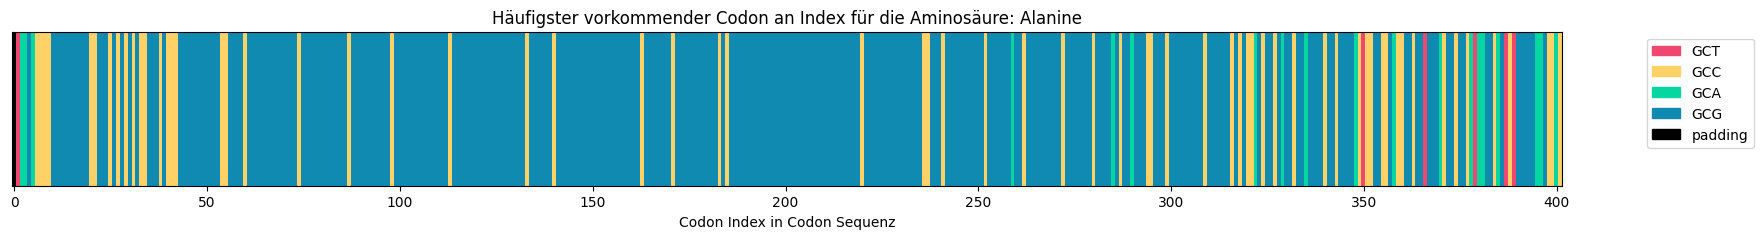

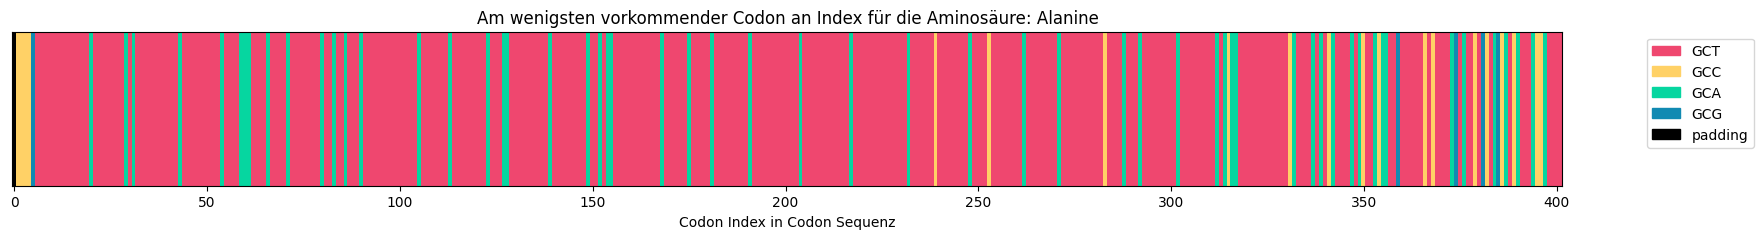

In [38]:
def visualize_max_min(colors, color_list, selected_aa, legend_text):

    cmap = ListedColormap(colors)
        # plot color_counts
    plt.figure(figsize=(20, 2))
    plt.imshow([color_list], aspect='auto', cmap=cmap, vmin=0, vmax=len(colors) - 1)
    plt.xlabel('Codon Index in Codon Sequenz')
    plt.title(legend_text)
    plt.yticks([])  # Hide y-axis ticks

    # Create a custom legend
    unique_codon_ids = list(set(range(0, len(translation_table[selected_aa[0]]))))
    unique_selected_codons = [translation_table[selected_aa[0]][i] for i in unique_codon_ids]
    patches = [mpl.patches.Patch(color=colors[i % len(colors)], label=unique_selected_codons[i]) for i in range(len(unique_selected_codons))]
    patches.append(mpl.patches.Patch(color=colors[-1], label='padding'))
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


legend_text = f'Häufigster vorkommender Codon an Index für die Aminosäure: {selected_amino_acid[1]}'
visualize_max_min(colors, color_max, selected_aa=selected_amino_acid, legend_text=legend_text)

legend_text = f'Am wenigsten vorkommender Codon an Index für die Aminosäure: {selected_amino_acid[1]}'
visualize_max_min(colors, color_min, selected_aa=selected_amino_acid, legend_text=legend_text)

- für jeden Index wird die Farbe des Codons dargstellt, die für diesen Index am häufigsten/seltestens auftritt
- padding und hohe varianz am Ende durch unterschiedliche Sequenzlängen
- vermehrt eine Farbe durch Codon Usage Bias erklärbar
- $c:i$         = Codon c tritt an Index i auf (Indizierung beginnt bei 1)

- $C$   = Matrix von $c:i$ für jedes $c_a$ in Sequenz

- n:                  Anzahl Codons in Sequenz
- Für jede Spalte:    j = 1, 2, ..., n:
    - Finde die Zahl:     x_j mit der höchsten Summe in Spalte j

- Hier wird folgende Sequenz dargestellt: $\underset{j=1}{\overset{n}{\text{max}}} (C_{j})$ und $\underset{j=1}{\overset{n}{\text{min}}} (C_{j})$

# Bereinigung des Codon Usage Bias
- n = Anzahl unterschiedlicher synonymer Codons
- Codon Usage Bias für Aminosäure $CUB = \{c_1,c_2,...,c_n\} $

- nun kann für jeden Index der Sequenz die Häufigkeit mit den Biases dividiert werden:
    - Codon Sequenzen ($C_s$) 
    - $B$ (bereinigte Sequenz) = $\{c / CUB_c ∣ c ∈ C_s \}$

- dieser Prozess kann sich auch als 2 Dimensionaler Array vorgestellt werden:
    - Spalte = Index in der Sequenz
    - Reihe = Häufigkeit des gewählten Codons
    - nun würde jede Spalte mit den Biases dividiert werden



In [39]:
# get the usage bias for the selected_aa
usage_bias_selected_aa = codon_usage_bias[organism][selected_amino_acid[0]]
# map the keys the usage bias based on the lookup table
usage_bias_selected_aa = {key: round(usage_bias_selected_aa[key],2) for key in translation_table[selected_amino_acid[0]]}

# cleaned up the bias
cleaned_color = color_counts.copy()
# match keys to the dataframe
usage_bias_series = {new_key: usage_bias_selected_aa[old_key] for new_key, old_key in zip(range(len(usage_bias_selected_aa)), usage_bias_selected_aa)}
# Multiply each column in cleaned_color with the corresponding value in anti_usage_bias
cleaned_color = cleaned_color.div(usage_bias_series, axis=0)

# get the relative values
cleaned_rel = cleaned_color.div(cleaned_color.sum(axis=0), axis=1)
# get the relative bias
cleaned_rel_bias = round(cleaned_rel.sum(axis=1) / len(cleaned_rel.columns),2)
print('cleaned bias', dict(cleaned_rel_bias))
print('sum of cleaned bias', round(cleaned_rel_bias.sum(),2))


cleaned bias {0: 0.24, 1: 0.25, 2: 0.26, 3: 0.25}
sum of cleaned bias 1.0


In [40]:
# create a list with colors for each column with the highest count
clean_color_max = []
clean_color_min = []
clean_count_max = []
clean_count_min = []
for col in cleaned_color.columns:
    if cleaned_color[col].sum() == 0:
        clean_color_max.append(color_padding)
        clean_color_min.append(color_padding)
        clean_count_max.append(0)
        clean_count_min.append(0)
        continue
    # get the color with the highest count
    clean_color_max.append(cleaned_color[col].idxmax())
    clean_color_min.append(cleaned_color[col].idxmin())

    clean_count_max.append(cleaned_color[col].max())
    clean_count_min.append(cleaned_color[col].min())


print('clean_color_max', clean_color_max)
print('clean_color_min', clean_color_min)
print('clean_count_max', clean_count_max)
print('clean_count_min', clean_count_min)


clean_color_max [5, 0, 0, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 3, 0, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0, 0, 0, 3, 1, 0, 1, 3, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 3, 3, 1, 1, 0, 3, 1, 2, 3, 0, 2, 0, 1, 3, 3, 2, 3, 2, 0, 1, 2, 0, 1, 0, 0, 2, 1, 2, 0, 3, 0, 2, 0, 2, 2, 0, 1, 1, 1, 0, 2, 1, 0, 0, 2, 3, 1, 2, 0, 0, 2, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 3, 2, 2, 0, 0, 1, 1, 3, 3, 1, 1, 3, 1, 2, 3, 3, 1, 1, 2, 2, 2, 3, 2, 2, 3, 0, 3, 2, 0, 0, 0, 0, 2, 0, 2, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 2, 2, 0, 3, 3, 2, 1, 3, 3, 2, 2, 2, 0, 0, 1, 2, 1, 3, 2, 3, 0, 3, 0, 2, 2, 3, 3, 2, 1, 2, 1, 2, 1, 1, 3, 0, 1, 1, 0, 1, 3, 3, 3, 2, 3, 2, 1, 1, 0, 1, 2, 1, 2, 3, 0, 0, 2, 2, 2, 1, 1, 0, 2, 1, 3, 1, 3, 2, 1, 3, 0, 0, 1, 2, 2, 2, 1, 3, 3, 0, 3, 3, 3, 2, 0, 2, 1, 3, 2, 3, 2, 1, 1, 1, 1, 2, 3, 2, 2, 3, 1, 3, 3, 0, 1, 3, 3, 1, 2, 1, 0, 1, 0, 2, 0, 3, 2, 3, 0, 0, 3, 2, 0, 0, 2, 1, 1, 1, 2, 3, 1, 3, 0, 0, 1, 0, 0, 3, 2, 0, 0, 2, 3, 3, 3, 3, 3, 1, 0, 0, 2, 1, 2, 2, 2, 1, 1, 3, 1,

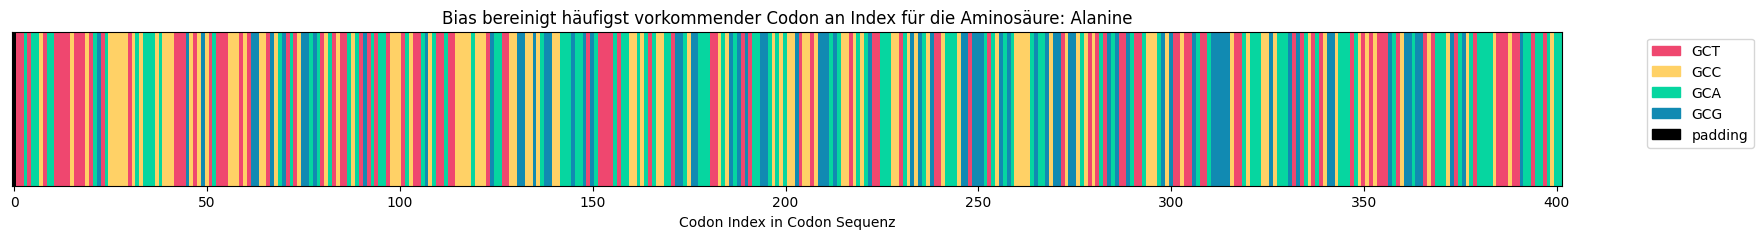

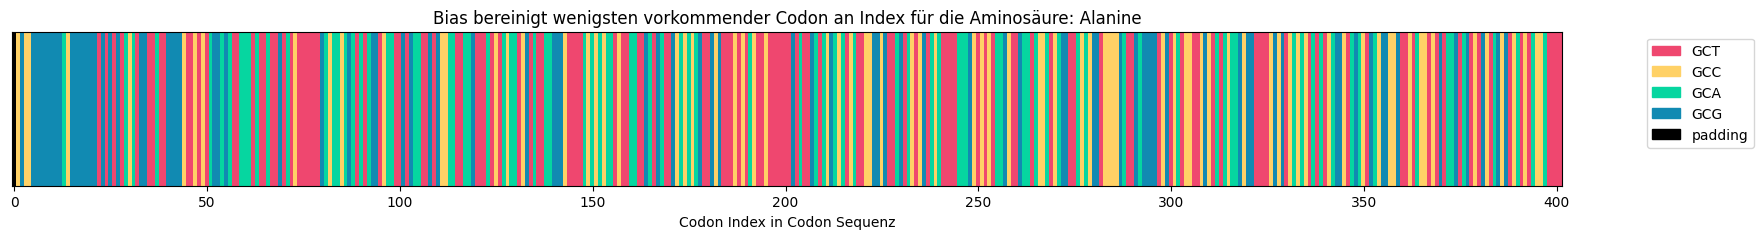

In [41]:
legend_text = f'Bias bereinigt häufigst vorkommender Codon an Index für die Aminosäure: {selected_amino_acid[1]}'
visualize_max_min(colors, clean_color_max, selected_aa=selected_amino_acid, legend_text=legend_text)

legend_text = f'Bias bereinigt wenigsten vorkommender Codon an Index für die Aminosäure: {selected_amino_acid[1]}'
visualize_max_min(colors, clean_color_min, selected_aa=selected_amino_acid, legend_text=legend_text)

- Codon Usage Bias bereinigte darstellung von max und min vorkommen der Codons
- $CB$ (bereinigte Matrix)
- Für jede Spalte:    j = 1, 2, ..., n:
- Hier wird folgende Sequenz dargestellt: $\underset{j=1}{\overset{n}{\text{max}}} (CB_{j})$ und $\underset{j=1}{\overset{n}{\text{min}}} (CB_{j})$

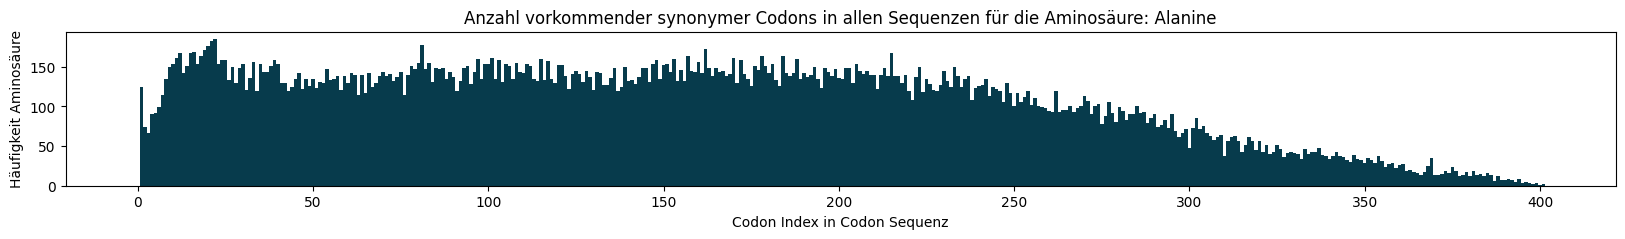

In [42]:
color_sum = color_counts.sum(axis=0)

def visualize_sum(color_sum, colors, legend_text):
    # plot color_counts
    plt.figure(figsize=(20, 2))
    # bar plot where the count_max is shown and the color is the color_max
    plt.bar(range(len(color_sum)), list(color_sum), color=colors[-2], width=1)
    plt.xlabel('Codon Index in Codon Sequenz')
    plt.title(legend_text)
    plt.ylabel('Häufigkeit Aminosäure')   # Hide y-axis ticks
    plt.show()

legend_text = f'Anzahl vorkommender synonymer Codons in allen Sequenzen für die Aminosäure: {selected_amino_acid[1]}'
visualize_sum(color_sum, colors=colors, legend_text=legend_text)

 - $G\{a\}:i$ = Gesamtanzahl an Kodierungen der Aminosäure $a$ über Sequenzen an index $i$

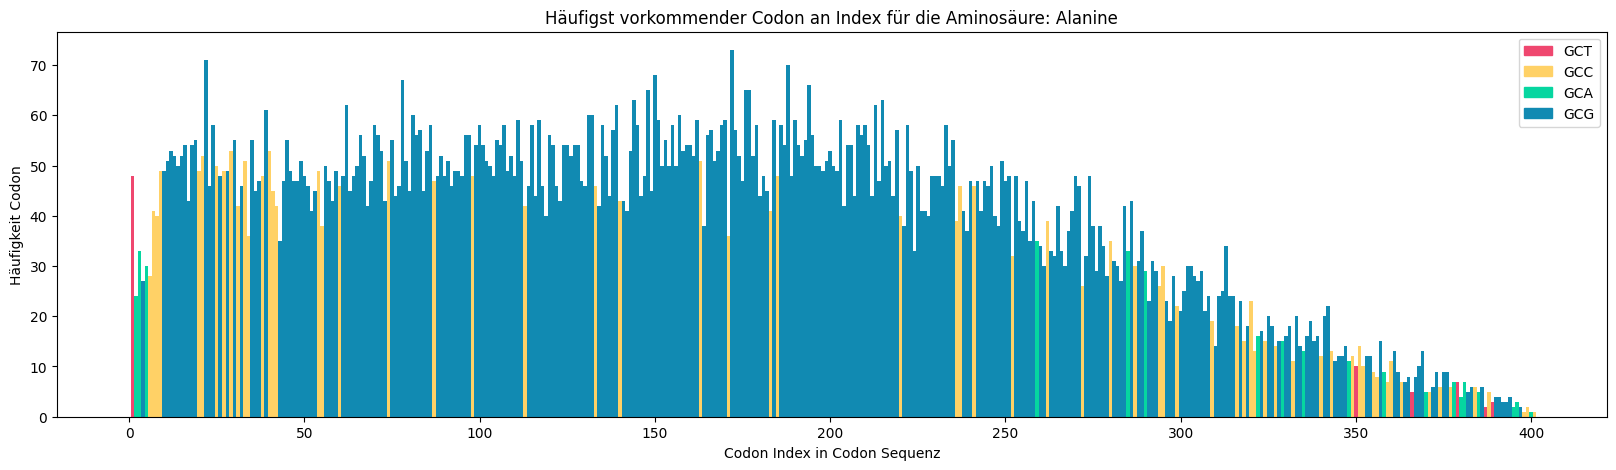

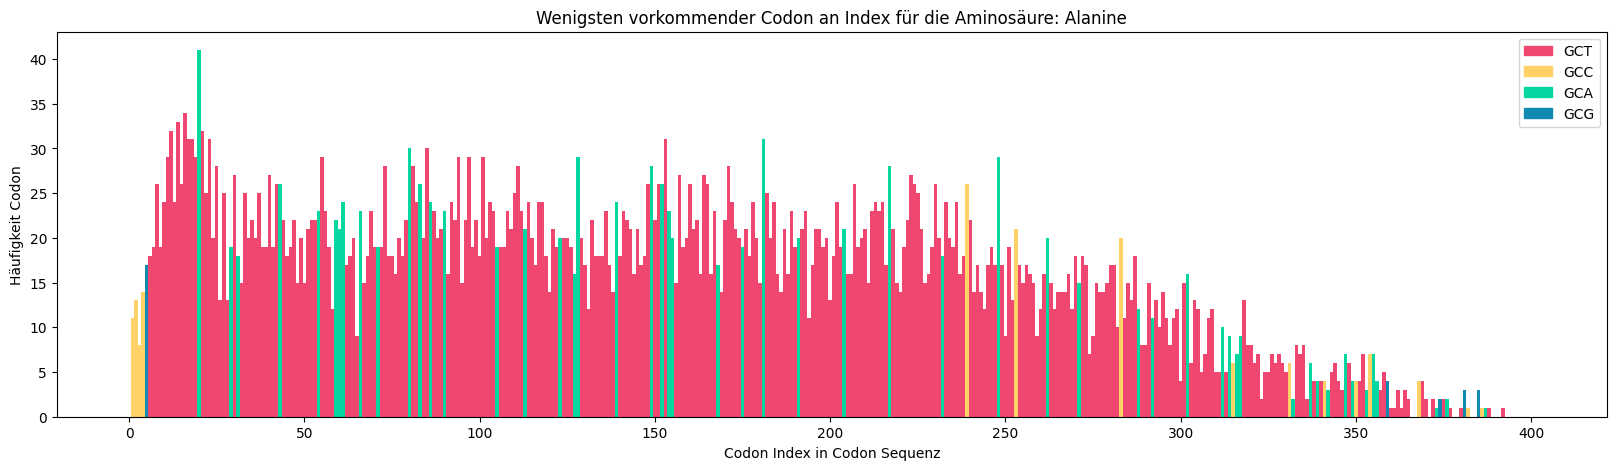

In [43]:
def visualize_amount(count_list, color_list, selected_aa, colors, title_text):
    # plot color_counts
    plt.figure(figsize=(20, 5))
    # bar plot where the count_max is shown and the color is the color_max
    plt.bar(range(len(count_list)), list(count_list), color=[colors[idx] for idx in color_list], width=1)
    plt.xlabel('Codon Index in Codon Sequenz')
    plt.title(title_text)
    plt.ylabel('Häufigkeit Codon')   # Hide y-axis ticks
    unique_codon_ids = list(set(range(0, len(translation_table[selected_aa[0]]))))
    unique_selected_codons = [translation_table[selected_aa[0]][i] for i in unique_codon_ids]
    patches = [mpl.patches.Patch(color=colors[i % len(colors)], label=unique_selected_codons[i]) for i in range(len(unique_selected_codons))]
    plt.legend(handles=patches, loc='upper right')
    plt.show()


title = f'Häufigst vorkommender Codon an Index für die Aminosäure: {selected_amino_acid[1]}'
visualize_amount(count_max, color_max, selected_aa=selected_amino_acid, colors=colors, title_text=title)
title = f'Wenigsten vorkommender Codon an Index für die Aminosäure: {selected_amino_acid[1]}'
visualize_amount(count_min, color_min, selected_aa=selected_amino_acid, colors=colors, title_text=title)

- die Farbe representiert welches Codon am häufigsten gewählt wurde
- die Häufigkeit zeigt an wie häufig dieses Codon gewählt wurde

- $G\_c\{a\}:i$ = Gesamtanzahl an Kodierungen des Codons $c$ über Sequenzen an index $i$

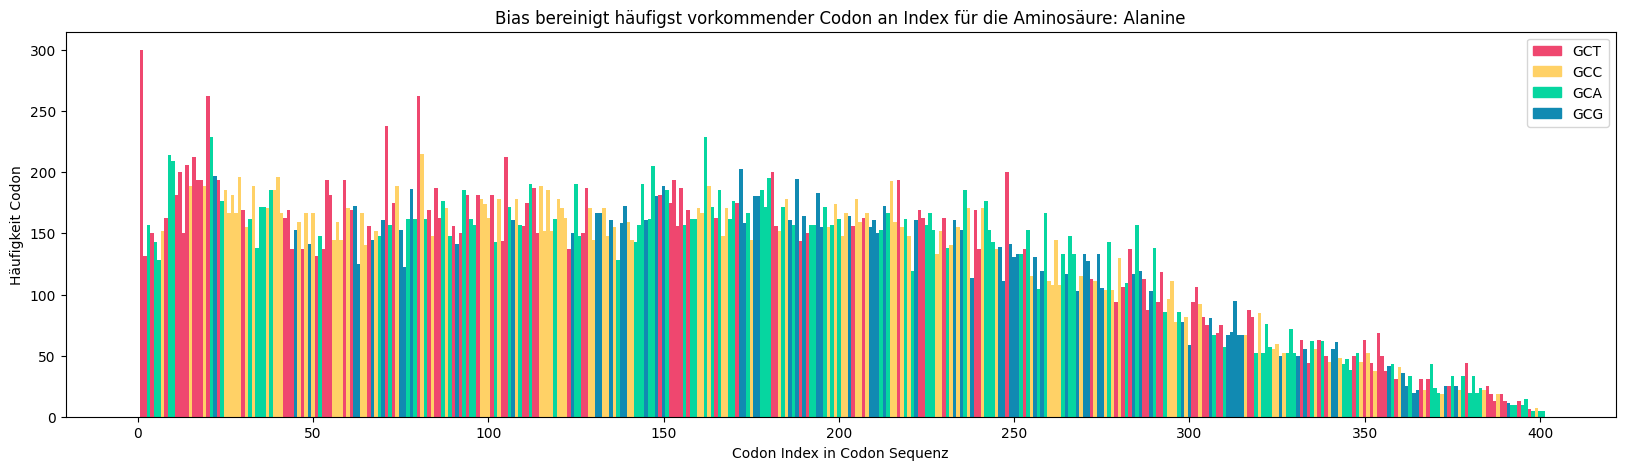

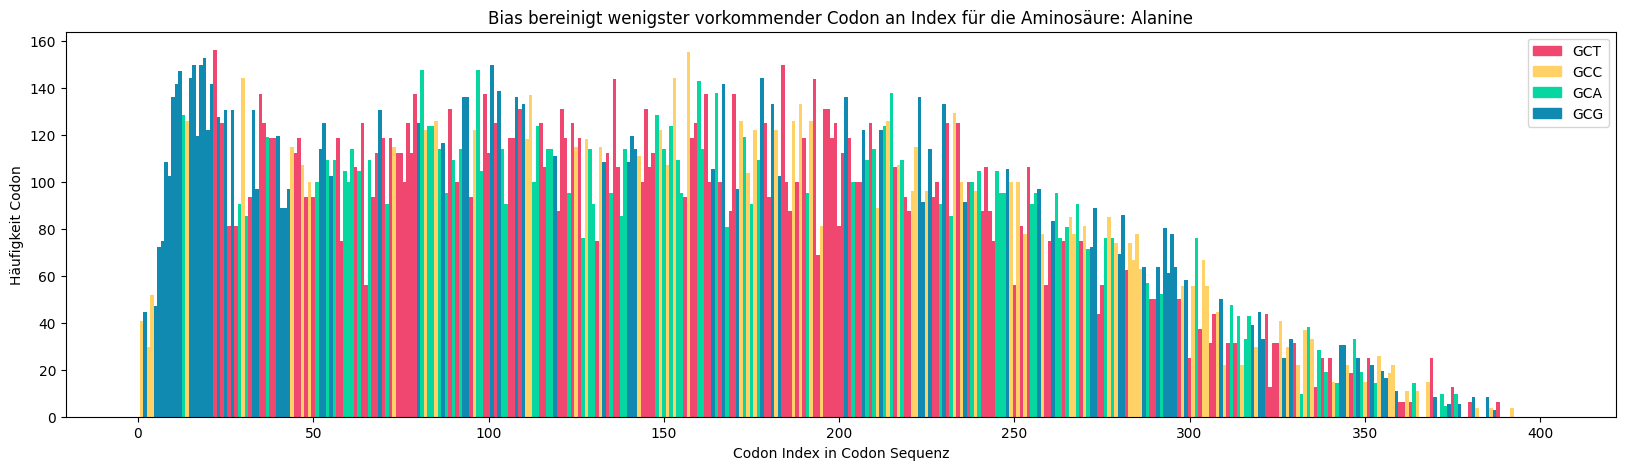

In [44]:
title = f'Bias bereinigt häufigst vorkommender Codon an Index für die Aminosäure: {selected_amino_acid[1]}'
visualize_amount(clean_count_max, clean_color_max, selected_aa=selected_amino_acid, colors=colors, title_text=title)
title = f'Bias bereinigt wenigster vorkommender Codon an Index für die Aminosäure: {selected_amino_acid[1]}'
visualize_amount(clean_count_min, clean_color_min, selected_aa=selected_amino_acid, colors=colors, title_text=title)

- $G\_c\{a\}:i$ = Gesamtanzahl an Kodierungen des Codons $c$ über bereinigte Sequenzen an index $i$

In [45]:
# for each position in the matrix, we want to count the number of times a color appears
df_bias_abs = df.apply(pd.Series.value_counts, axis=0).fillna(0)
# drop the last which is the padding
df_bias_abs = df_bias_abs.drop(color_padding)
df_bias_abs = df_bias_abs.drop(color_default)
# calculate the relative bias
df_bias_rel = df_bias_abs / df_bias_abs.sum()

# Fill NaN values with 0
df_bias_rel = df_bias_rel.fillna(0)
df_bias_rel

,0,1,2,3,4,5,6,7,8,9,...,392,393,394,395,396,397,398,399,400,401
0,0.0,0.387097,0.283784,0.181818,0.263736,0.195652,0.181818,0.166667,0.194030,0.126667,...,0.142857,0.0,0.25,0.25,0.2,0.25,0.0,0.000000,0.0,0.0
1,0.0,0.088710,0.175676,0.121212,0.153846,0.293478,0.282828,0.359649,0.298507,0.326667,...,0.142857,0.0,0.25,0.00,0.0,0.25,0.5,0.666667,0.0,0.5
2,0.0,0.338710,0.324324,0.500000,0.285714,0.326087,0.272727,0.236842,0.216418,0.300000,...,0.285714,0.4,0.00,0.50,0.6,0.00,0.5,0.333333,1.0,0.5
3,0.0,0.185484,0.216216,0.196970,0.296703,0.184783,0.262626,0.236842,0.291045,0.246667,...,0.428571,0.6,0.50,0.25,0.2,0.50,0.0,0.000000,0.0,0.0


## Codon Index Rate (CIR) 
Anteil des Auftretens eines bestimmten “synonymen” Codons an einem bestimmten Index

Für ein einzelnes Codon c{a} wird die CIR für Index i wie folgt berechnet:

$CIR\_c\{a\}:i = G\_c\{a\}:i / G\_a:i$

Nimmt Werte zwischen 0 (Codon wird nicht verwendet) und 1 (Codon wird ausschließlich verwendet) an

Problem: Ist nicht definiert, wenn Aminosäure a nie an Index i kodiert wird innerhalb der Menge an betrachteten Sequenzen


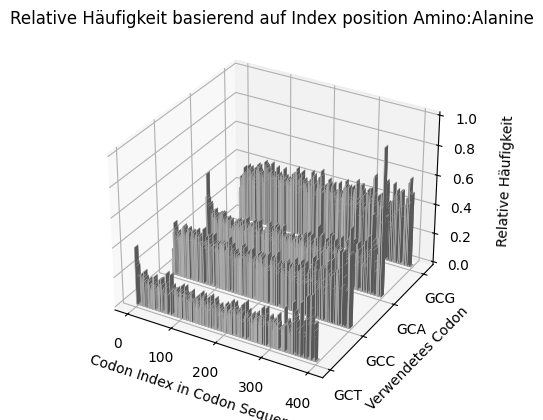

<Figure size 1000x1500 with 0 Axes>

In [46]:
def visualize_3d_abs(df_bias_rel, selected_aa, colors):
    # Assuming df is your DataFrame and it's already defined
    x = np.arange(df_bias_rel.shape[1])  # x axis - columns of the DataFrame
    y = np.arange(df_bias_rel.shape[0])  # y axis - rows of the DataFrame
    x, y = np.meshgrid(x, y)
    z = df_bias_rel.values  # z axis - values of the DataFrame

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

        # Define your colors
    #colors = ['red', 'green', 'blue', 'yellow', 'lightgrey']

    # Flatten your data
    x_data = x.flatten()
    y_data = y.flatten()
    z_data = z.flatten()

    color_arr = np.array(['lightgrey' for i in z_data])
    # every 2nd element color 0
    #color_arr[1::100] = colors[0]

    
    # Plot a basic wireframe
    x_width = 1
    y_depth = 0.1
    ax.bar3d(x_data, y_data, np.zeros(len(z_data)), x_width, y_depth, z_data, color=color_arr)

    ax.set_xlabel('Codon Index in Codon Sequenz')
    ax.set_ylabel('Verwendetes Codon')
    ax.set_zlabel('Relative Häufigkeit', labelpad=10)

    ax.set_yticks(range(len(translation_table[selected_aa[0]])))
    ax.set_yticklabels(translation_table[selected_aa[0]])

    plt.title(f'Relative Häufigkeit basierend auf Index position Amino:{selected_aa[1]}')
    plt.figure(figsize=(10,15))
    plt.tight_layout()  # Adjust layout
    plt.show()





visualize_3d_abs(df_bias_rel, selected_aa=selected_amino_acid, colors=colors)

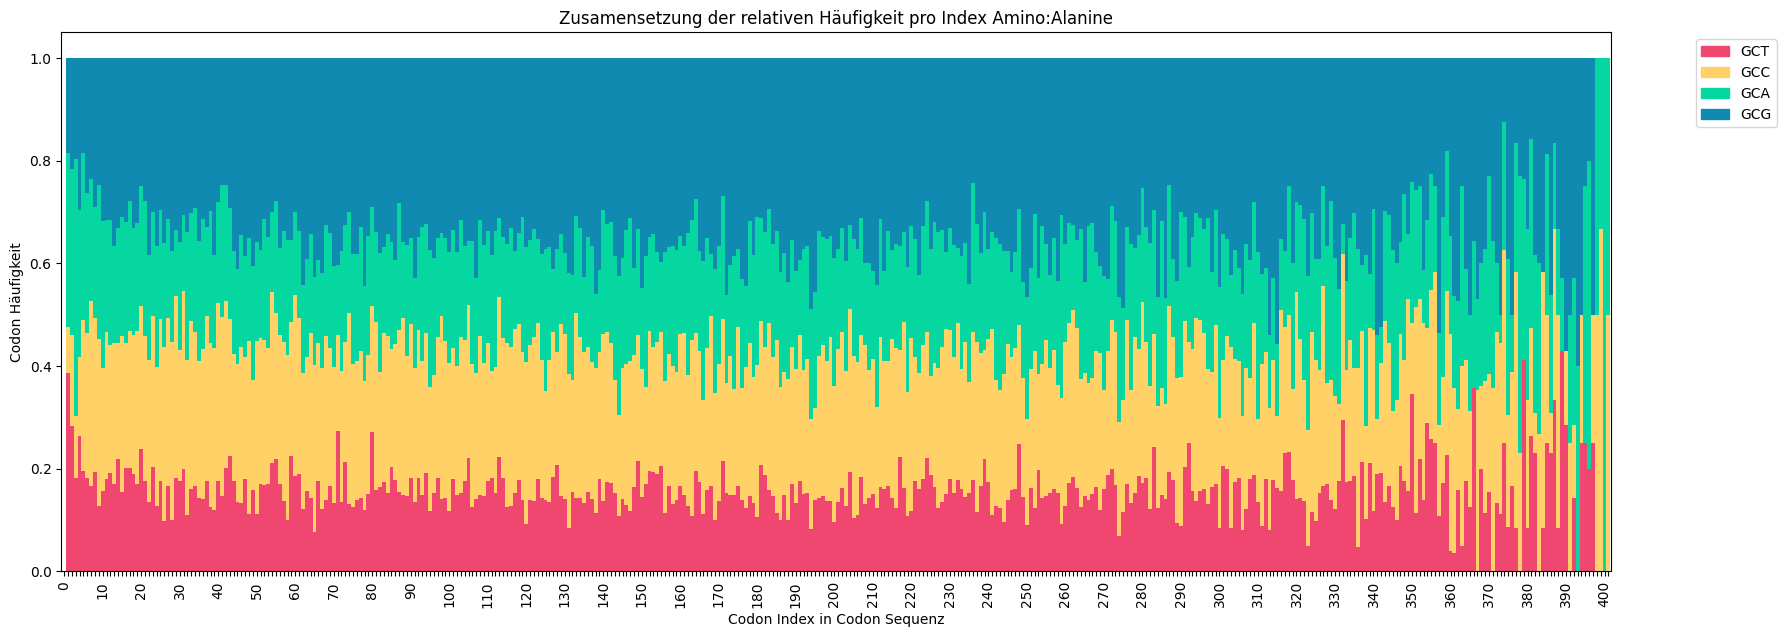

In [47]:
def visualize_stacked_rel(df_bias_rel, selected_aa, colors, title):
    # Transpose the DataFrame
    df_transposed = df_bias_rel.T

    # Create a stacked bar plot
    ax = df_transposed.plot.bar(stacked=True, color=colors, figsize=(20, 7), width=1)

    # ax set x axis to range from 0 to the number of columns in the DataFrame
    ax.set_xticks(range(df_transposed.shape[0]))
    # dont display each number on the x-axis only every 10th
    ax.set_xticklabels([i if i % 10 == 0 else '' for i in range(df_transposed.shape[0])])

    # Add labels and title
    ax.set_xlabel('Codon Index in Codon Sequenz')
    ax.set_ylabel('Codon Häufigkeit')
    ax.set_title(title)
    # Create a custom legend
    unique_codon_ids = list(set(range(0, len(translation_table[selected_aa[0]]))))
    unique_selected_codons = [translation_table[selected_aa[0]][i] for i in unique_codon_ids]
    patches = [mpl.patches.Patch(color=colors[i % len(colors)], label=unique_selected_codons[i]) for i in range(len(unique_selected_codons))]
    ax.legend(handles=patches,bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.show()
title= 'Zusamensetzung der relativen Häufigkeit pro Index Amino:' + selected_amino_acid[1]
visualize_stacked_rel(df_bias_rel, selected_aa=selected_amino_acid, colors=colors, title=title)

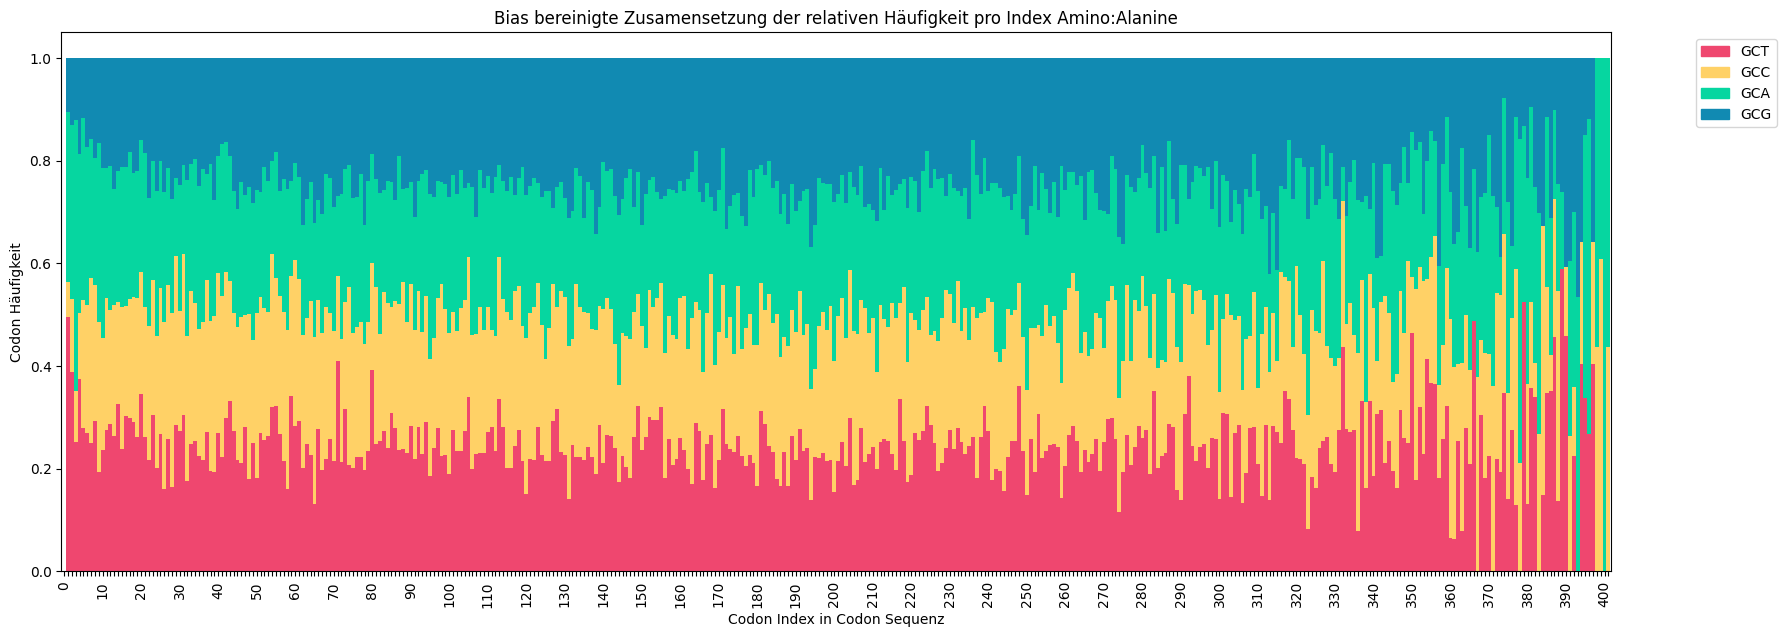

In [48]:
title= 'Bias bereinigte Zusamensetzung der relativen Häufigkeit pro Index Amino:' + selected_amino_acid[1]
visualize_stacked_rel(cleaned_rel, selected_aa=selected_amino_acid, colors=colors, title=title)

## Bias Corrected Codon Index Rate (BCCIR) 
Anteil des Auftretens eines bestimmten “synonymen” Codons an einem bestimmten Index nach der Bias bereinigung

Für ein einzelnes Codon c{a} wird die BCCIR für Index i wie folgt berechnet:

- $b\_c$ = Bias für entsprechendes Codon

$BCCIR\_c\{a\}:i = CIR\_c\{a\}:i / b\_c$

In [49]:
df_bias_rel.index = translation_table[selected_amino_acid[0]].copy()

rounded_usage_bias_selected_aa = {key: round(value, 2) for key, value in usage_bias_selected_aa.items()}
print(rounded_usage_bias_selected_aa)

# subtract the usage bias
#df_bias_sub = df_bias_rel.sub(usage_bias_selected_aa, axis=0)
df_bias_sub = df_bias_rel.copy()

# map the usage bias to the index
mapped_usage_bias = df_bias_sub.index.map(usage_bias_selected_aa)

# iter column wise and subtract usage bias
for col in df_bias_rel.columns:
    # if sum of col is 0, we skip it
    if df_bias_rel[col].sum() == 0:
        continue
    df_bias_sub[col] = df_bias_sub[col] - mapped_usage_bias

# Fill NaN values with 0
df_bias_sub = df_bias_sub.fillna(0)
df_bias_sub

{'GCT': 0.16, 'GCC': 0.27, 'GCA': 0.21, 'GCG': 0.36}


,0,1,2,3,4,5,6,7,8,9,...,392,393,394,395,396,397,398,399,400,401
GCT,0.0,0.227097,0.123784,0.021818,0.103736,0.035652,0.021818,0.006667,0.034030,-0.033333,...,-0.017143,-0.16,0.09,0.09,0.04,0.09,-0.16,-0.160000,-0.16,-0.16
GCC,0.0,-0.181290,-0.094324,-0.148788,-0.116154,0.023478,0.012828,0.089649,0.028507,0.056667,...,-0.127143,-0.27,-0.02,-0.27,-0.27,-0.02,0.23,0.396667,-0.27,0.23
GCA,0.0,0.128710,0.114324,0.290000,0.075714,0.116087,0.062727,0.026842,0.006418,0.090000,...,0.075714,0.19,-0.21,0.29,0.39,-0.21,0.29,0.123333,0.79,0.29
GCG,0.0,-0.174516,-0.143784,-0.163030,-0.063297,-0.175217,-0.097374,-0.123158,-0.068955,-0.113333,...,0.068571,0.24,0.14,-0.11,-0.16,0.14,-0.36,-0.360000,-0.36,-0.36


## Bias Subtracted Codon Index Rate (BSCIR) 
Differenz zwischen gesamten Biases und den index spezifischen Biases

Für ein einzelnes Codon c{a} wird die BSCIR für Index i wie folgt berechnet:

- $b\_c$ = Bias für entsprechendes Codon

$BSCIR\_c\{a\}:i = CIR\_c\{a\}:i - b\_c$


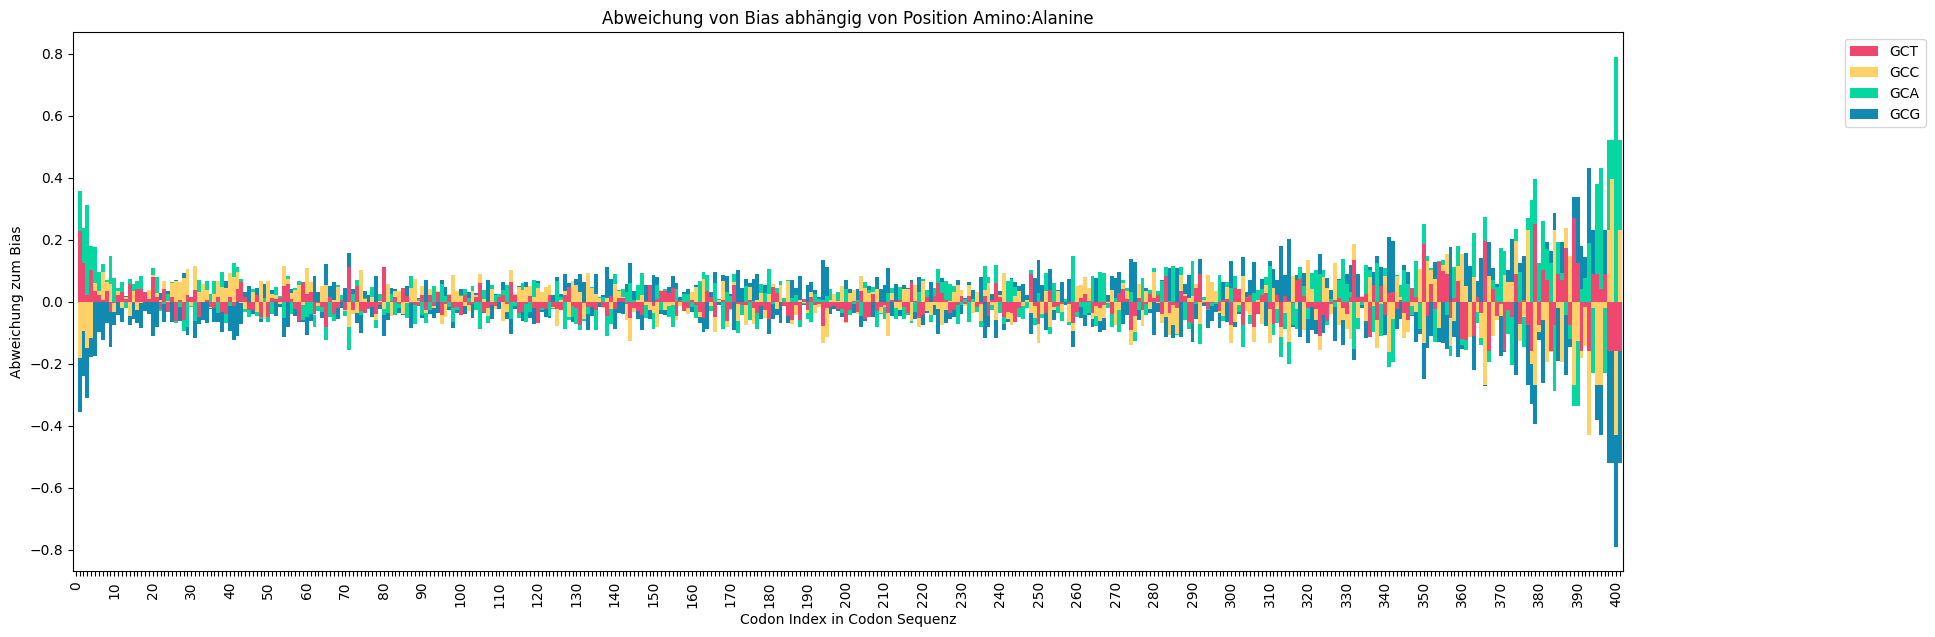

In [50]:
def visualize_stacked_sub(df_bias_sub, selected_aa, colors):
    # Transpose the DataFrame
    df_transposed = df_bias_sub.T

    # Create a stacked bar plot
    ax = df_transposed.plot.bar(stacked=True, color=colors, figsize=(20, 7), width=1)

    # ax set x axis to range from 0 to the number of columns in the DataFrame
    ax.set_xticks(range(df_transposed.shape[0]))
    # dont display each number on the x-axis only every 10th
    ax.set_xticklabels([i if i % 10 == 0 else '' for i in range(df_transposed.shape[0])])

    # Add labels and title
    ax.set_xlabel('Codon Index in Codon Sequenz')
    ax.set_ylabel('Abweichung zum Bias')
    ax.set_title('Abweichung von Bias abhängig von Position Amino:' + selected_aa[1])

    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Display the plot
    plt.show()

visualize_stacked_sub(df_bias_sub, selected_aa=selected_amino_acid, colors=colors)

- hier wurde der Bias von der relativen Häufigkeit abgezogen
- negative Werte zeigen wenn ein Codon unterrepresentiert wurde

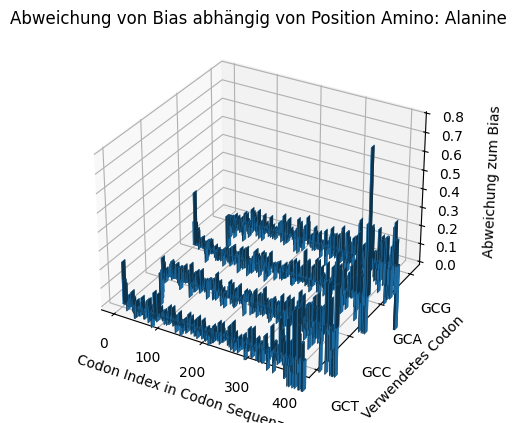

<Figure size 1000x1500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [51]:
def visualize_3d_rel(df_bias_sub, selected_aa, colors):
    x = np.arange(df_bias_sub.shape[1])  # x axis - columns of the DataFrame
    y = np.arange(df_bias_sub.shape[0])  # y axis - rows of the DataFrame
    x, y = np.meshgrid(x, y)
    z = df_bias_sub.values  # z axis - values of the DataFrame

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot a basic wireframe
    x_width = 1
    y_depth = 0.1
    ax.bar3d(x.flatten(), y.flatten(), np.zeros(len(z.flatten())), x_width, y_depth, z.flatten())

    ax.set_xlabel('Codon Index in Codon Sequenz')
    ax.set_ylabel('Verwendetes Codon')
    ax.set_zlabel('Abweichung zum Bias', labelpad=10)

    ax.set_yticks(range(len(translation_table[selected_aa[0]])))
    ax.set_yticklabels(translation_table[selected_aa[0]], position=(5, 0))
    # move y axis label to the right
    ax.tick_params(axis='y', which='major', pad=10)
    # move y label to the right
    ax.yaxis.labelpad = 10


    plt.title(f'Abweichung von Bias abhängig von Position Amino: {selected_aa[1]}')
    plt.figure(figsize=(10,15))
    plt.tight_layout()  # Adjust layout
    plt.show()

    main_title_size = 20
    title_size = 10
    label_size = 10

    # get the number of rows
    # round up to the next integer

    # plot_rows = math.ceil(len(df_bias_sub.index) / 2)
    # plot_cols = math.ceil(len(df_bias_sub.index) / 2)


    # new plots 2x2
    # fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(10, 10))
    # fig.suptitle(f'Abweichung von Bias abhängig von Position Amino: {selected_aa[1]}', fontsize=main_title_size)
    # fig.subplots_adjust(top=5)

    # # each codon a different subplot, so only row
    # df_1 = df_bias_sub.iloc[0]
    # df_2 = df_bias_sub.iloc[1]
    # df_3 = df_bias_sub.iloc[2]
    # df_4 = df_bias_sub.iloc[3]

    
    # # Plot for df_1
    # ax[0, 0].bar(df_1.index, df_1.values)
    # ax[0, 0].set_title(f'Codon: {translation_table[selected_aa[0]][0]}', size=title_size)
    # ax[0, 0].set_xlabel('Codon Index in Codon Sequenz', size=label_size)
    # ax[0, 0].set_ylabel('Abweichung zum Bias', size=label_size)

    # # Plot for df_2
    # ax[0, 1].bar(df_2.index, df_2.values)
    # ax[0, 1].set_title(f'Codon: {translation_table[selected_aa[0]][1]}', size=title_size)
    # ax[0, 1].set_xlabel('Codon Index in Codon Sequenz', size=label_size)

    # # Plot for df_3
    # ax[1, 0].bar(df_3.index, df_3.values)
    # ax[1, 0].set_title(f'Codon: {translation_table[selected_aa[0]][2]}', size=title_size)
    # ax[1, 0].set_xlabel('Codon Index in Codon Sequenz', size=label_size)
    # ax[1, 0].set_ylabel('Abweichung zum Bias', size=label_size)

    # # Plot for df_4
    # ax[1, 1].bar(df_4.index, df_4.values)
    # ax[1, 1].set_title(f'Codon: {translation_table[selected_aa[0]][3]}', size=title_size)
    # ax[1, 1].set_xlabel('Codon Index in Codon Sequenz', size=label_size)


    plt.tight_layout()
    plt.show()



visualize_3d_rel(df_bias_sub, selected_aa=selected_amino_acid, colors=colors)

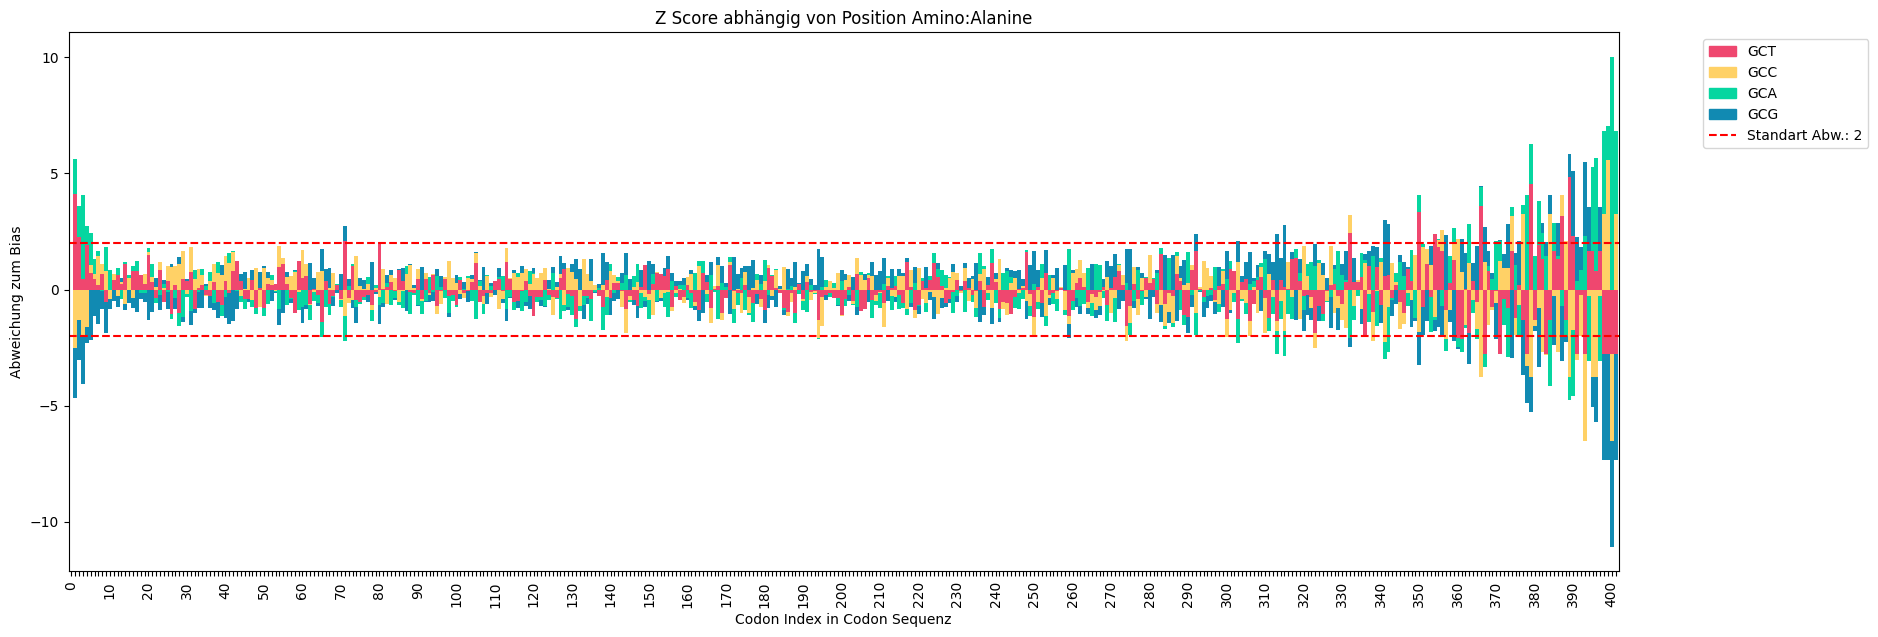

In [52]:
# for each row calculate the varaince and the standard deviation
df_stats = df_bias_rel.copy()
vars = df_stats.var(axis=1)
stds = df_stats.std(axis=1)
# calculate the mean
means = df_stats.mean(axis=1)
# calc the z-score
for col in df_stats.columns:
    # if sum of col is 0, we skip it
    if df_stats[col].sum() == 0:
        continue
    df_stats[col] = (df_stats[col] - means) / stds

abnormal_threshold = 2
# get the abnormal values set others to 0
#df_stats = df_stats.applymap(lambda x: x if abs(x) > abnormal_threshold else 0)


selected_aa = selected_amino_acid



def visualize_stacked_z(df_bias_sub, selected_aa, abnormal_threshold, colors):
    # Transpose the DataFrame
    df_transposed = df_bias_sub.T

    # Create a stacked bar plot
    ax = df_transposed.plot.bar(stacked=True, color=colors, figsize=(20, 7), width=1)

    # add two horizontal lines for the threshold
    ax.axhline(abnormal_threshold, color='r', linestyle='--')
    ax.axhline(-abnormal_threshold, color='r', linestyle='--')



    # ax set x axis to range from 0 to the number of columns in the DataFrame
    ax.set_xticks(range(df_transposed.shape[0]))
    # dont display each number on the x-axis only every 10th
    ax.set_xticklabels([i if i % 10 == 0 else '' for i in range(df_transposed.shape[0])])

    # Add labels and title
    ax.set_xlabel('Codon Index in Codon Sequenz')
    ax.set_ylabel('Abweichung zum Bias')
    ax.set_title('Z Score abhängig von Position Amino:' + selected_aa[1])

    #plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    unique_codon_ids = list(set(range(0, len(translation_table[selected_aa[0]]))))
    unique_selected_codons = [translation_table[selected_aa[0]][i] for i in unique_codon_ids]
    patches = [mpl.patches.Patch(color=colors[i % len(colors)], label=unique_selected_codons[i]) for i in range(len(unique_selected_codons))]
    # add the threshold to the legend
    patches.append(mpl.lines.Line2D([], [], color='red', linestyle='--', label=f'Standart Abw.: {abnormal_threshold}'))
    ax.legend(handles=patches,bbox_to_anchor=(1.05, 1), loc='upper left')


    # Display the plot
    plt.show()

visualize_stacked_z(df_stats, selected_aa=selected_amino_acid, abnormal_threshold=abnormal_threshold ,colors=colors)



## Z Score

$$Z = \frac{{X - \mu}}{{\sigma}}$$

- $Z $ für den Z-Score,
- $X$  für den Wert, für den du den Z-Score berechnen möchtest,
- $μ$  für den Mittelwert der Stichprobe oder Population, und
- $σ$  für die Standardabweichung der Stichprobe oder Population.

## PMDS Wahrscheinlichkeit synonyme Codons gleich

$S: sei \ ein\ Tupel\ aller \ synonymen \ Codons \ einer \ Sequenz$



$a_i : ein \ Codon \in S\ an \ der \ Stelle \ i $


$P_{gleich}(a) =  \frac{|(a: a_{i-1}=a_i )|}{|(a :a_i=a, 1 \leq i \leq |S|-1  )|}  $


In [53]:
def plotChangeTabelle(tabelle, usage_bias, organism):
    
    genetic_code = CodonTable.unambiguous_dna_by_id[1]
    translation_table = {}
    for i in genetic_code.forward_table:
        translation_table.setdefault(genetic_code.forward_table[i], []).append(i)
    # translation_table['*'] = ['TAA', 'TAG', 'TGA']

    print(translation_table)

    for k,v in translation_table.items():           
        sns.boxplot(tabelle[v])
          
        plt.xlabel("Codon")
        plt.ylabel("P_gleich")
        column_names = tabelle[v].columns.tolist()
        for i in range(len(column_names)):
            column_names[i] = column_names[i] + '\n'  +str(round(usage_bias[k][column_names[i]],3))
            
    
        plt.xticks(range(0,len(column_names)), column_names,rotation=0, ha='right')
        plt.title('P_Gleich für: ' +organism, fontweight='bold', loc='left')
        plt.title('Aminosäure:' +k)
        plt.gcf().text(-0.025, 0.025, 'Usage Bias:', fontsize=10)
        plt.show()

{'F': ['TTT', 'TTC'], 'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'], 'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'], 'Y': ['TAT', 'TAC'], 'C': ['TGT', 'TGC'], 'W': ['TGG'], 'P': ['CCT', 'CCC', 'CCA', 'CCG'], 'H': ['CAT', 'CAC'], 'Q': ['CAA', 'CAG'], 'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'], 'I': ['ATT', 'ATC', 'ATA'], 'M': ['ATG'], 'T': ['ACT', 'ACC', 'ACA', 'ACG'], 'N': ['AAT', 'AAC'], 'K': ['AAA', 'AAG'], 'V': ['GTT', 'GTC', 'GTA', 'GTG'], 'A': ['GCT', 'GCC', 'GCA', 'GCG'], 'D': ['GAT', 'GAC'], 'E': ['GAA', 'GAG'], 'G': ['GGT', 'GGC', 'GGA', 'GGG']}


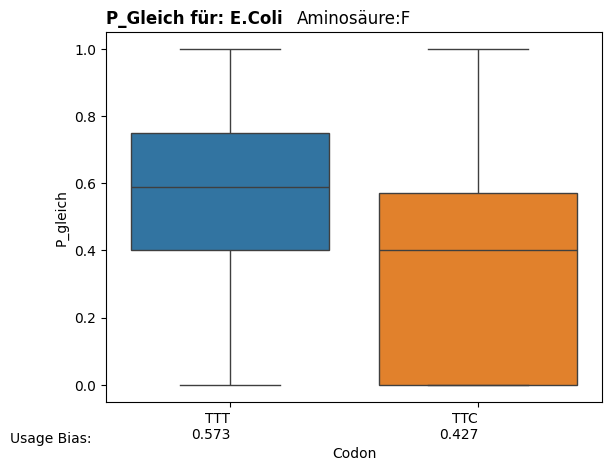

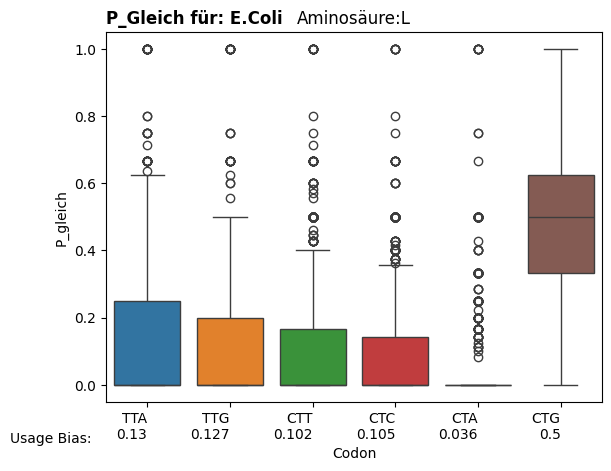

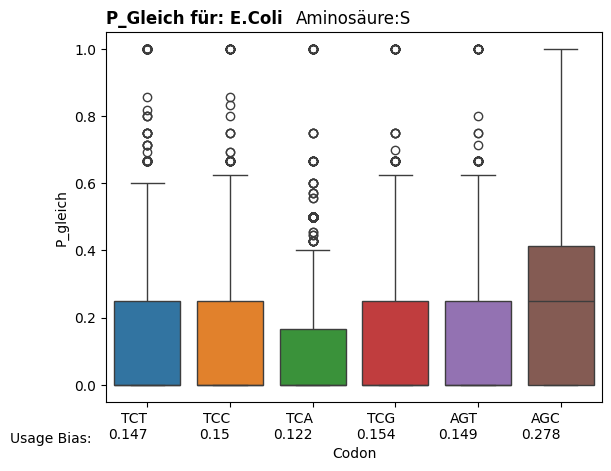

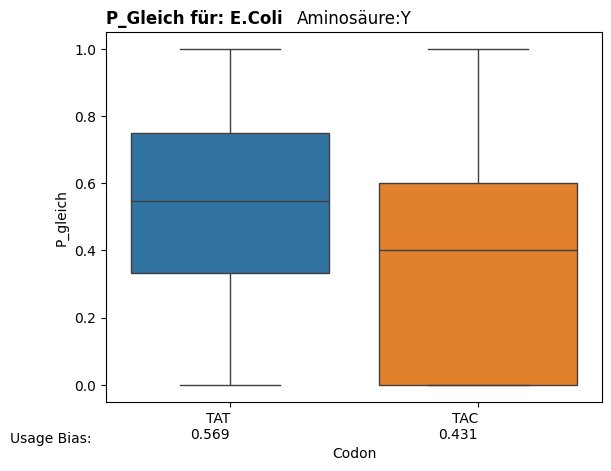

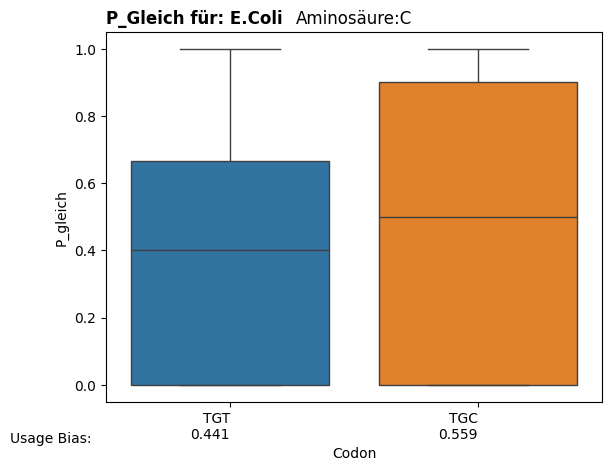

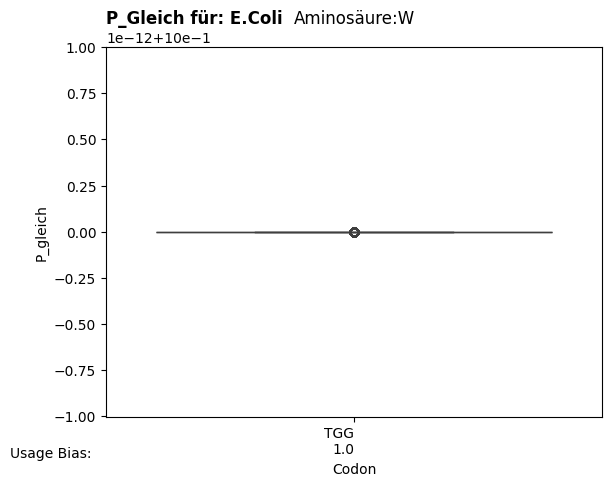

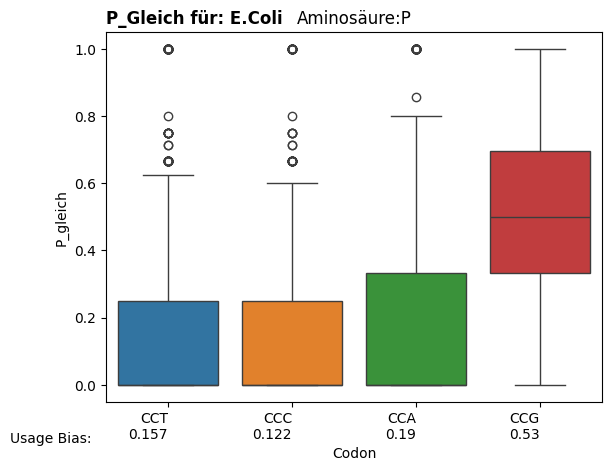

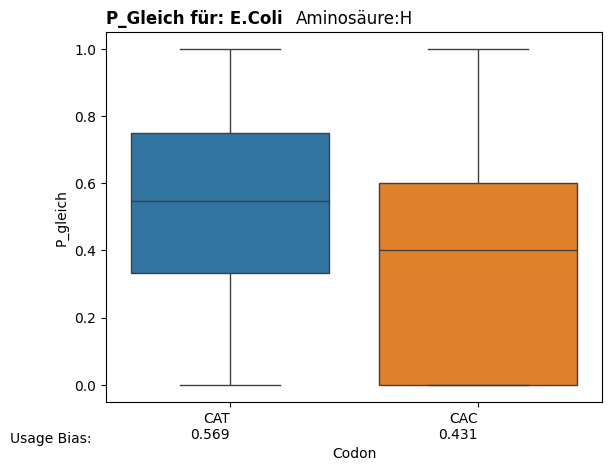

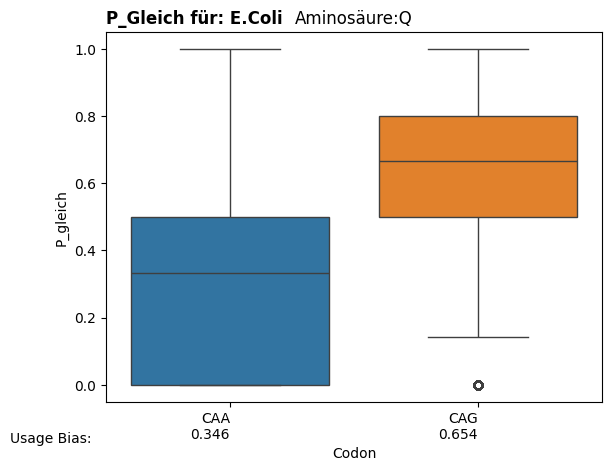

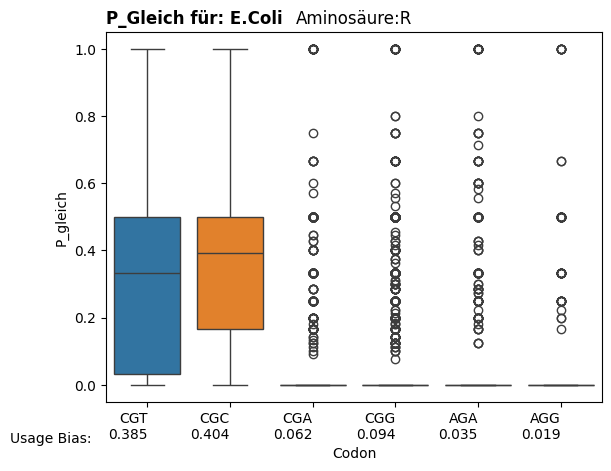

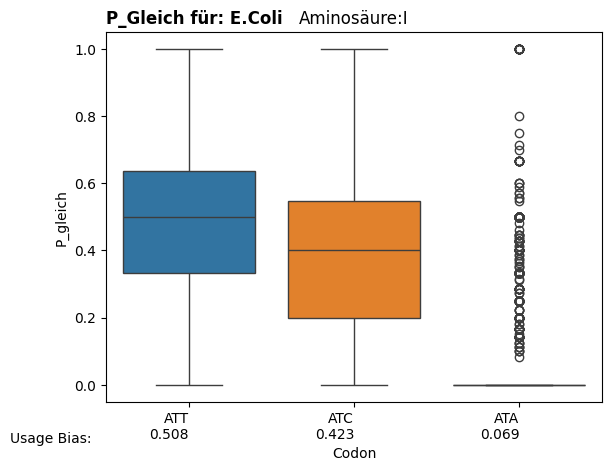

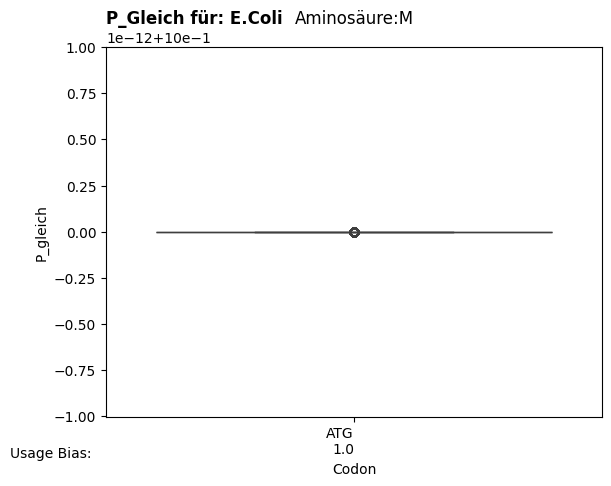

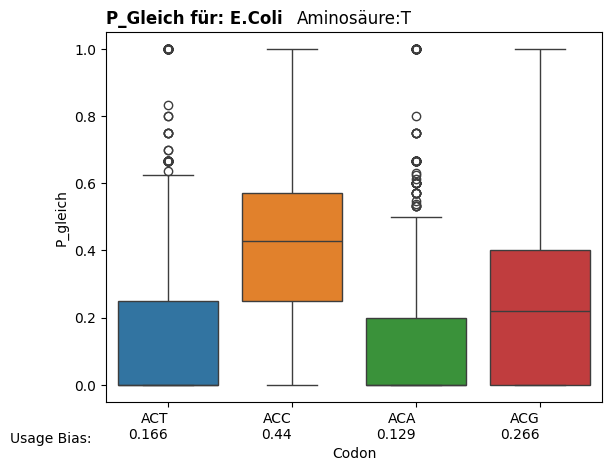

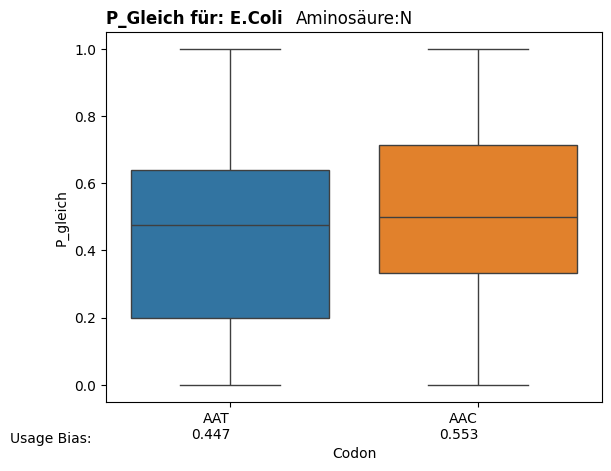

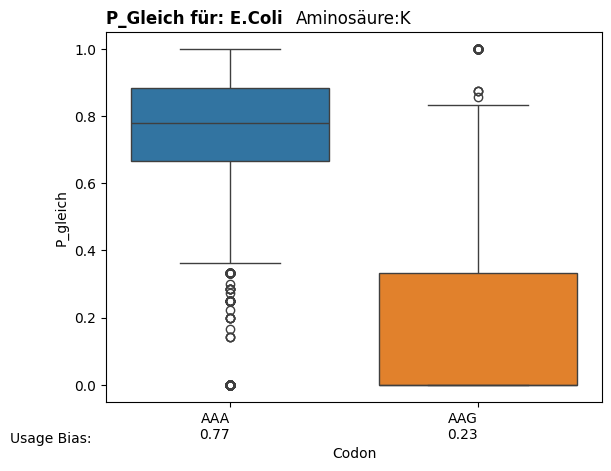

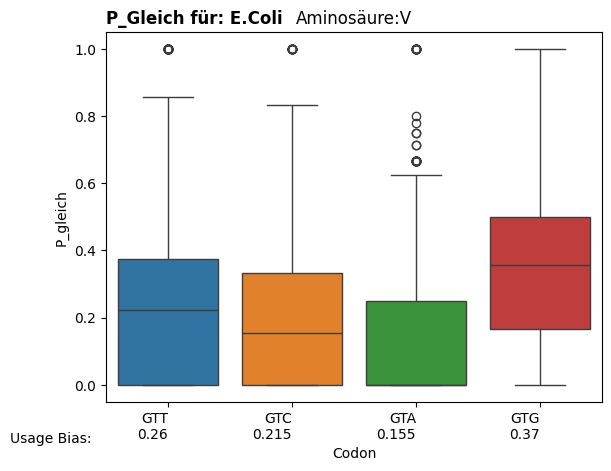

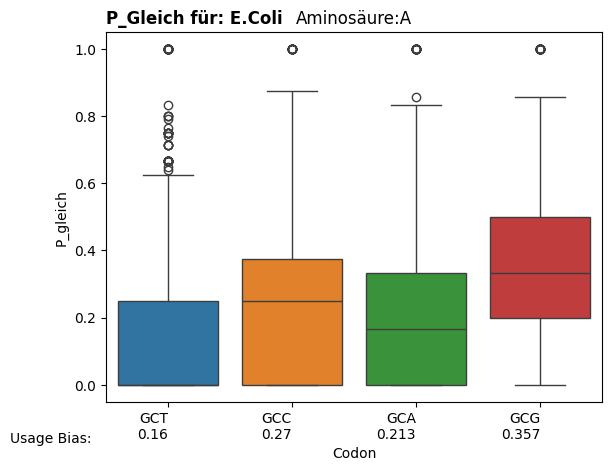

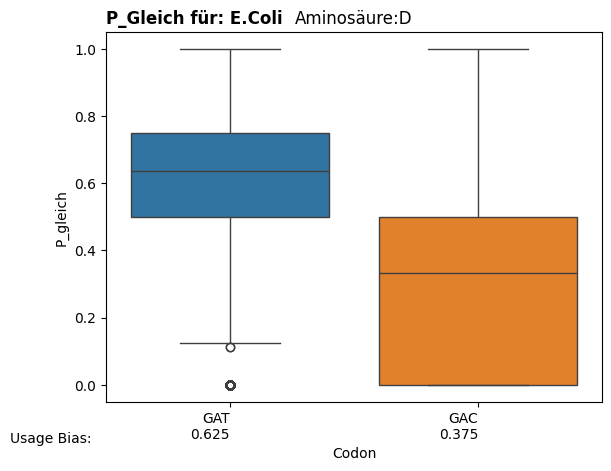

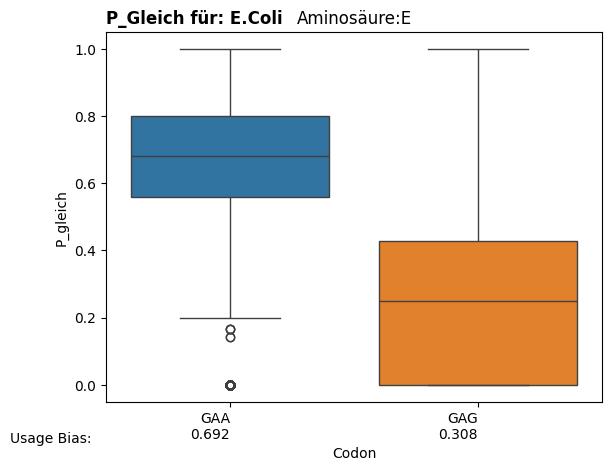

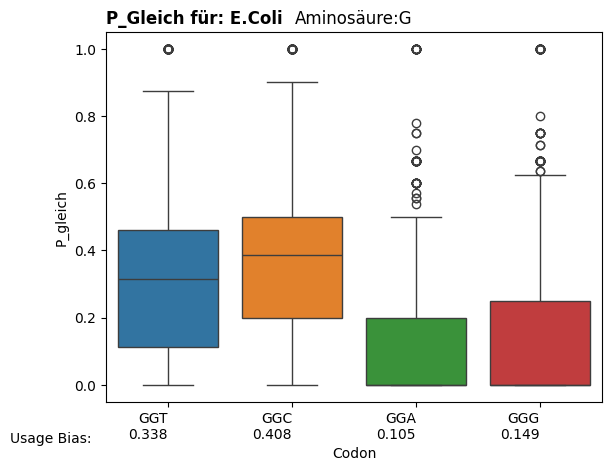

In [54]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[0]

tabelle = pd.read_pickle(f"../data/{organism}/changeTable.pkl")
usage_bias = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
plotChangeTabelle(tabelle,usage_bias,organism)